## read outputs from two runs, the control run (roof albedo = 0.2) and the high roof albedo run, both from 2022-07-19 to 2022-07-23


In [207]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable 
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  # Import inset_axes


## now read the outpus from WRF

In [208]:
start_datetime_data = pd.Timestamp('2022-07-19 00:00:00')
time_interval = pd.Timedelta(hours=1)  # assuming 1-hour interval, adjust if different
start_time_desired = pd.Timestamp('2022-07-20 00:00:00')
end_time_desired = pd.Timestamp('2022-07-25 00:00:00')
start_index = int((start_time_desired - start_datetime_data) / time_interval)
end_index = int((end_time_desired - start_datetime_data) / time_interval)

folder_paths = [
    ("d03/", "d03_alb60/"),
    ("d03_MYNN/", "d03_alb60_MYNN/"),    
    ("d03_MYJ/", "d03_alb60_MYJ/")
]

converstion_factor = 0.001*0.24/1004.5
AH = 0
AH_T2_value = 0

# Define the variables you want to load
#variables_to_load = ['TSK', 'T2', 'SWDOWN', 'FRC_URB2D', 'U10', 'V10', 'LU_INDEX','UTYPE_URB', 'TR_URB', 'TB_URB','TG_URB', 'ALPHAR_URB2D', 'CHS_URB2D', 'CHS2_URB2D', 'TS_URB', 'TC_URB', ]

variables_to_read = ["TC_URB", "TB_URB", "TG_URB", "TA_URB", "TR_URB",  "TSK", "TS_URB", "T2",'SWDOWN', 'U10', 'V10',
                     "ALPHAC_URB2D", "ALPHAB_URB2D", "ALPHAG_URB2D", "ALPHAR_URB2D",
                     "UTYPE_URB", "LU_INDEX", "FRC_URB2D",
                     "HFX","SH_URB","CHS_URB2D", "CHS2_URB2D", 
                     "ALB_RUL2D", "ALB_URB2D","EMISS"]

# Set font sizes
axis_label_font_size = 16  # Font size for x and y axis labels
title_font_size = 14       # Font size for the subplot titles
tick_label_font_size = 14  # Font size for tick labels
legend_font_size = 14      # Font size for legend

# Define a function to process a dataset
def process_dataset(folder):
    folder_path_ctl = folder[0]
    folder_path_alb = folder[1]

    # Read in the control dataset
    ds_ctl_tem = xr.open_mfdataset(os.path.join(folder_path_ctl, "wrfout_d03*"), combine='nested', concat_dim='Time', engine='netcdf4')   
    # Select the desired time range
    ds_ctl = ds_ctl_tem.sel(Time=slice(start_index, end_index))
    # Select and load the specified variables
    ds_ctl = ds_ctl[variables_to_read]
    
    # Read in and process the albedo dataset
    ds_alb_tem = xr.open_mfdataset(os.path.join(folder_path_alb, "wrfout_d03*"), combine='nested', concat_dim='Time', engine='netcdf4')
    ds_alb = ds_alb_tem.sel(Time=slice(start_index, end_index))
    ds_alb = ds_alb[variables_to_read]
    
    # ROOF ALBEDO VALUES
    ds_ctl['ROOF_ALBEDO'] = xr.full_like(ds_ctl['UTYPE_URB'], fill_value=np.nan, dtype=float)
    ds_ctl['ROOF_ALBEDO'] = ds_ctl['ROOF_ALBEDO'].where(ds_ctl['UTYPE_URB'] != 1, 0.2)
    ds_ctl['ROOF_ALBEDO'] = ds_ctl['ROOF_ALBEDO'].where(ds_ctl['UTYPE_URB'] != 2, 0.2)
    ds_ctl['ROOF_ALBEDO'] = ds_ctl['ROOF_ALBEDO'].where(ds_ctl['UTYPE_URB'] != 3, 0.2)
    
    if "d03_alb60/" in folder or "d03_alb60_MYJ/" in folder or "d03_alb60_MYNN/" in folder or "d03_alb60_SD1/" in folder or "d03_alb60_SD2/" in folder:
        ds_alb['ROOF_ALBEDO'] = xr.full_like(ds_alb['UTYPE_URB'], fill_value=np.nan, dtype=float)
        ds_alb['ROOF_ALBEDO'] = ds_alb['ROOF_ALBEDO'].where(ds_alb['UTYPE_URB'] != 1, 0.6)
        ds_alb['ROOF_ALBEDO'] = ds_alb['ROOF_ALBEDO'].where(ds_alb['UTYPE_URB'] != 2, 0.6)
        ds_alb['ROOF_ALBEDO'] = ds_alb['ROOF_ALBEDO'].where(ds_alb['UTYPE_URB'] != 3, 0.6)

    elif "d03_alb80/" in folder:

        ds_alb['ROOF_ALBEDO'] = xr.full_like(ds_alb['UTYPE_URB'], fill_value=np.nan, dtype=float)
        ds_alb['ROOF_ALBEDO'] = ds_alb['ROOF_ALBEDO'].where(ds_alb['UTYPE_URB'] != 1, 0.8)
        ds_alb['ROOF_ALBEDO'] = ds_alb['ROOF_ALBEDO'].where(ds_alb['UTYPE_URB'] != 2, 0.8)
        ds_alb['ROOF_ALBEDO'] = ds_alb['ROOF_ALBEDO'].where(ds_alb['UTYPE_URB'] != 3, 0.8)

    # Assigning ROOF_WIDTH, ROAD_WIDTH, ZR_TBL based on UTYPE_URB
    ds_ctl['ROOF_WIDTH'] = xr.full_like(ds_ctl['UTYPE_URB'], fill_value=np.nan, dtype=float)
    ds_ctl['ROOF_WIDTH'] = ds_ctl['ROOF_WIDTH'].where(ds_ctl['UTYPE_URB'] != 1, 8.3)
    ds_ctl['ROOF_WIDTH'] = ds_ctl['ROOF_WIDTH'].where(ds_ctl['UTYPE_URB'] != 2, 9.4)
    
    ds_ctl['ROAD_WIDTH'] = xr.full_like(ds_ctl['UTYPE_URB'], fill_value=np.nan, dtype=float)
    ds_ctl['ROAD_WIDTH'] = ds_ctl['ROAD_WIDTH'].where(ds_ctl['UTYPE_URB'] != 1, 8.3)
    ds_ctl['ROAD_WIDTH'] = ds_ctl['ROAD_WIDTH'].where(ds_ctl['UTYPE_URB'] != 2, 9.4)

    ds_ctl['ZR_TBL'] = xr.full_like(ds_ctl['UTYPE_URB'], fill_value=np.nan, dtype=float)
    ds_ctl['ZR_TBL'] = ds_ctl['ZR_TBL'].where(ds_ctl['UTYPE_URB'] != 1, 5)
    ds_ctl['ZR_TBL'] = ds_ctl['ZR_TBL'].where(ds_ctl['UTYPE_URB'] != 2, 7.5)

    if "d03_morphology1/" in folder[0] or "d03_morphology1_MYJ/" in folder[0]:
        ds_ctl['ROOF_WIDTH'] = ds_ctl['ROOF_WIDTH'].where(ds_ctl['UTYPE_URB'] != 3, 10)
        ds_ctl['ROAD_WIDTH'] = ds_ctl['ROAD_WIDTH'].where(ds_ctl['UTYPE_URB'] != 3, 23.3)
        ds_ctl['ZR_TBL'] = ds_ctl['ZR_TBL'].where(ds_ctl['UTYPE_URB'] != 3, 10)
    elif "control_20220719_test1_d04_morphology2/" in folder[0] or "control_20220719_test1_d04_morphology2_YSU/" in folder[0]:
        ds_ctl['ROOF_WIDTH'] = ds_ctl['ROOF_WIDTH'].where(ds_ctl['UTYPE_URB'] != 3, 10)    
        ds_ctl['ROAD_WIDTH'] = ds_ctl['ROAD_WIDTH'].where(ds_ctl['UTYPE_URB'] != 3, 6.7)
        ds_ctl['ZR_TBL'] = ds_ctl['ZR_TBL'].where(ds_ctl['UTYPE_URB'] != 3, 10)
    elif "control_20220719_test1_d04_morphology3/" in folder[0] or "control_20220719_test1_d04_morphology3_YSU/" in folder[0]:
        ds_ctl['ROOF_WIDTH'] = ds_ctl['ROOF_WIDTH'].where(ds_ctl['UTYPE_URB'] != 3, 10)    
        ds_ctl['ROAD_WIDTH'] = ds_ctl['ROAD_WIDTH'].where(ds_ctl['UTYPE_URB'] != 3, 6.7)
        ds_ctl['ZR_TBL'] = ds_ctl['ZR_TBL'].where(ds_ctl['UTYPE_URB'] != 3, 20)
    else:
        ds_ctl['ROOF_WIDTH'] = ds_ctl['ROOF_WIDTH'].where(ds_ctl['UTYPE_URB'] != 3, 10)
        ds_ctl['ROAD_WIDTH'] = ds_ctl['ROAD_WIDTH'].where(ds_ctl['UTYPE_URB'] != 3, 10)
        ds_ctl['ZR_TBL'] = ds_ctl['ZR_TBL'].where(ds_ctl['UTYPE_URB'] != 3, 10)
    
    # Calculate R_TBL
    ds_ctl['R_TBL'] = ds_ctl['ROOF_WIDTH'] / (ds_ctl['ROAD_WIDTH'] + ds_ctl['ROOF_WIDTH'])
    
    # Calculation for HGT_TBL
    ds_ctl['HGT_TBL'] = ds_ctl['ZR_TBL'] / (ds_ctl['ROAD_WIDTH'] + ds_ctl['ROOF_WIDTH'])

    # Calculation for RW_TBL
    ds_ctl['RW_TBL'] = 1.0 - ds_ctl['R_TBL']

    # Calculation for W_TBL
    ds_ctl['W_TBL'] = 2.0 * 1.0 * ds_ctl['HGT_TBL']  
    
    # Assigning ROOF_WIDTH, ROAD_WIDTH, ZR_TBL based on UTYPE_URB
    ds_alb['ROOF_WIDTH'] = xr.full_like(ds_alb['UTYPE_URB'], fill_value=np.nan, dtype=float)
    ds_alb['ROOF_WIDTH'] = ds_alb['ROOF_WIDTH'].where(ds_alb['UTYPE_URB'] != 1, 8.3)
    ds_alb['ROOF_WIDTH'] = ds_alb['ROOF_WIDTH'].where(ds_alb['UTYPE_URB'] != 2, 9.4)

    ds_alb['ROAD_WIDTH'] = xr.full_like(ds_alb['UTYPE_URB'], fill_value=np.nan, dtype=float)
    ds_alb['ROAD_WIDTH'] = ds_alb['ROAD_WIDTH'].where(ds_alb['UTYPE_URB'] != 1, 8.3)
    ds_alb['ROAD_WIDTH'] = ds_alb['ROAD_WIDTH'].where(ds_alb['UTYPE_URB'] != 2, 9.4)

    ds_alb['ZR_TBL'] = xr.full_like(ds_alb['UTYPE_URB'], fill_value=np.nan, dtype=float)
    ds_alb['ZR_TBL'] = ds_alb['ZR_TBL'].where(ds_alb['UTYPE_URB'] != 1, 5)
    ds_alb['ZR_TBL'] = ds_alb['ZR_TBL'].where(ds_alb['UTYPE_URB'] != 2, 7.5)

    if "d03_morphology1/" in folder[0] or "d03_morphology1_MYJ/" in folder[0]:
        ds_alb['ROOF_WIDTH'] = ds_alb['ROOF_WIDTH'].where(ds_alb['UTYPE_URB'] != 3, 10)
        ds_alb['ROAD_WIDTH'] = ds_alb['ROAD_WIDTH'].where(ds_alb['UTYPE_URB'] != 3, 23.3)
        ds_alb['ZR_TBL'] = ds_alb['ZR_TBL'].where(ds_alb['UTYPE_URB'] != 3, 10)
    elif "control_20220719_test1_d04_morphology2/" in folder[0] or "control_20220719_test1_d04_morphology2_YSU/" in folder[0]:
        ds_alb['ROOF_WIDTH'] = ds_alb['ROOF_WIDTH'].where(ds_alb['UTYPE_URB'] != 3, 10)    
        ds_alb['ROAD_WIDTH'] = ds_alb['ROAD_WIDTH'].where(ds_alb['UTYPE_URB'] != 3, 6.7)
        ds_alb['ZR_TBL'] = ds_alb['ZR_TBL'].where(ds_alb['UTYPE_URB'] != 3, 10)
    elif "control_20220719_test1_d04_morphology3/" in folder[0] or "control_20220719_test1_d04_morphology3_YSU/" in folder[0]:
        ds_alb['ROOF_WIDTH'] = ds_alb['ROOF_WIDTH'].where(ds_alb['UTYPE_URB'] != 3, 10)    
        ds_alb['ROAD_WIDTH'] = ds_alb['ROAD_WIDTH'].where(ds_alb['UTYPE_URB'] != 3, 6.7)
        ds_alb['ZR_TBL'] = ds_alb['ZR_TBL'].where(ds_alb['UTYPE_URB'] != 3, 20)
    else:
        ds_alb['ROOF_WIDTH'] = ds_alb['ROOF_WIDTH'].where(ds_alb['UTYPE_URB'] != 3, 10)
        ds_alb['ROAD_WIDTH'] = ds_alb['ROAD_WIDTH'].where(ds_alb['UTYPE_URB'] != 3, 10)
        ds_alb['ZR_TBL'] = ds_alb['ZR_TBL'].where(ds_alb['UTYPE_URB'] != 3, 10)

    # Calculate R_TBL
    ds_alb['R_TBL'] = ds_alb['ROOF_WIDTH'] / (ds_alb['ROAD_WIDTH'] + ds_alb['ROOF_WIDTH'])

    # Calculation for HGT_TBL
    ds_alb['HGT_TBL'] = ds_alb['ZR_TBL'] / (ds_alb['ROAD_WIDTH'] + ds_alb['ROOF_WIDTH'])

    # Calculation for RW_TBL
    ds_alb['RW_TBL'] = 1.0 - ds_alb['R_TBL']

    # Calculation for W_TBL
    ds_alb['W_TBL'] = 2.0 * 1.0 * ds_alb['HGT_TBL']

    #ds_ctl['T_GRASS'] = (ds_ctl['TSK'] - ds_ctl['TS_URB'] * ds_ctl['FRC_URB2D']) / (1 - ds_ctl['FRC_URB2D'])
    #ds_ctl['TSK_NEW1'] =  (ds_ctl['R_TBL'] * ds_ctl['TR_URB'] +  ds_ctl['RW_TBL'] * ds_ctl['TC_URB']) * ds_ctl['FRC_URB2D'] +  ds_ctl['T_GRASS'] * (1 - ds_ctl['FRC_URB2D'])
    #ds_ctl['TSK_NEW2'] =  (ds_ctl['R_TBL'] * ds_ctl['TR_URB'] + ds_ctl['W_TBL']* ds_ctl['TB_URB'] + ds_ctl['RW_TBL'] * ds_ctl['TG_URB']) * ds_ctl['FRC_URB2D'] +  ds_ctl['T_GRASS'] * (1 - ds_ctl['FRC_URB2D'])
    #ds_ctl['TSK_NEW3'] =  ds_ctl['R_TBL'] * ds_ctl['TR_URB'] * ds_ctl['FRC_URB2D'] 

    #ds_alb['T_GRASS'] = (ds_alb['TSK'] - ds_alb['TS_URB'] * ds_ctl['FRC_URB2D']) / (1 - ds_ctl['FRC_URB2D'])
    #ds_alb['TSK_NEW1'] =  (ds_ctl['R_TBL'] * ds_alb['TR_URB'] + ds_ctl['RW_TBL'] * ds_alb['TC_URB']) * ds_ctl['FRC_URB2D'] +  ds_alb['T_GRASS'] * (1 - ds_ctl['FRC_URB2D']) 
    #ds_alb['TSK_NEW2'] =  (ds_ctl['R_TBL'] * ds_alb['TR_URB'] + ds_ctl['W_TBL']* ds_alb['TB_URB'] +  ds_ctl['RW_TBL'] * ds_alb['TG_URB']) * ds_ctl['FRC_URB2D'] +  ds_alb['T_GRASS'] * (1 - ds_ctl['FRC_URB2D'])
    #ds_alb['TSK_NEW3'] =  ds_ctl['R_TBL'] * ds_alb['TR_URB'] * ds_ctl['FRC_URB2D']


    # Calculate and store additional variables

    ds_ctl['TC_URB_DIAG'] = (ds_ctl['RW_TBL']*ds_ctl['TA_URB']*ds_ctl['ALPHAC_URB2D'] + \
                            ds_ctl['RW_TBL']*ds_ctl['TG_URB']*ds_ctl['ALPHAG_URB2D'] + \
                            ds_ctl['W_TBL']*ds_ctl['TB_URB']*ds_ctl['ALPHAB_URB2D'] + AH*converstion_factor) / \
                            (ds_ctl['RW_TBL']*ds_ctl['ALPHAC_URB2D'] + 
                            ds_ctl['RW_TBL']*ds_ctl['ALPHAG_URB2D'] + 
                            ds_ctl['W_TBL']*ds_ctl['ALPHAB_URB2D'])
    
    ds_ctl['TS_RUL'] =  (ds_ctl['TSK'] -   ds_ctl['TS_URB']*ds_ctl['FRC_URB2D'] ) / (1 - ds_ctl['FRC_URB2D'])            

    ds_ctl['Qu'] = ds_ctl['R_TBL']*(ds_ctl['TR_URB']-ds_ctl['TA_URB'])*ds_ctl['ALPHAR_URB2D']/converstion_factor + \
                                ds_ctl['RW_TBL']*(ds_ctl['TC_URB']-ds_ctl['TA_URB'])*ds_ctl['ALPHAC_URB2D']/converstion_factor 
                                
    ds_ctl['Qu2'] = ds_ctl['R_TBL']*(ds_ctl['TR_URB']-ds_ctl['TA_URB'])*ds_ctl['ALPHAR_URB2D']/converstion_factor + \
                    ds_ctl['W_TBL']*(ds_ctl['TB_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAB_URB2D']/converstion_factor + \
                    ds_ctl['RW_TBL']*(ds_ctl['TG_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAG_URB2D']/converstion_factor + \
                        + AH
                        
    ds_ctl['QR']= ds_ctl['R_TBL']*(ds_ctl['TR_URB']-ds_ctl['TA_URB'])*ds_ctl['ALPHAR_URB2D']/converstion_factor

    ds_ctl['QT'] = (ds_ctl['TSK'] - ds_ctl['TA_URB'])* ds_ctl['CHS_URB2D']
                            
    ds_ctl['Tu'] = ds_ctl['Qu']/ds_ctl['CHS_URB2D'] + ds_ctl['TA_URB']
        
    ds_ctl['TS_URB_DIAG'] = ds_ctl['TS_RUL']* (1 - ds_ctl['FRC_URB2D']) + ((ds_ctl['R_TBL']*(ds_ctl['TR_URB']-ds_ctl['TA_URB'])*ds_ctl['ALPHAR_URB2D']/converstion_factor + \
                    ds_ctl['W_TBL']*(ds_ctl['TB_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAB_URB2D']/converstion_factor + \
                    ds_ctl['RW_TBL']*(ds_ctl['TG_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAG_URB2D']/converstion_factor + \
                        + AH)/ds_ctl['CHS_URB2D'] + ds_ctl['TA_URB']) *ds_ctl['FRC_URB2D']

    ds_ctl['HFX_corrected'] = ds_ctl['HFX']-AH_T2_value*ds_ctl['FRC_URB2D']
        
    ds_ctl['Q_RUL'] =  (ds_ctl['HFX_corrected'] - ds_ctl['SH_URB']*ds_ctl['FRC_URB2D']) / (1 - ds_ctl['FRC_URB2D'])

    ds_ctl['T2_URB_DIAG'] = ds_ctl['TS_RUL']* (1 - ds_ctl['FRC_URB2D']) + ((ds_ctl['R_TBL']*(ds_ctl['TR_URB']-ds_ctl['TA_URB'])*ds_ctl['ALPHAR_URB2D']/converstion_factor + \
                    ds_ctl['W_TBL']*(ds_ctl['TB_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAB_URB2D']/converstion_factor + \
                    ds_ctl['RW_TBL']*(ds_ctl['TG_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAG_URB2D']/converstion_factor + \
                        + AH)/ds_ctl['CHS_URB2D'] + ds_ctl['TA_URB']) *ds_ctl['FRC_URB2D'] -  \
            (ds_ctl['Q_RUL']*(1 - ds_ctl['FRC_URB2D'])+(ds_ctl['R_TBL']*(ds_ctl['TR_URB']-ds_ctl['TA_URB'])*ds_ctl['ALPHAR_URB2D']/converstion_factor + \
                                        ds_ctl['W_TBL']*(ds_ctl['TB_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAB_URB2D']/converstion_factor + \
                                        ds_ctl['RW_TBL']*(ds_ctl['TG_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAG_URB2D']/converstion_factor + \
                                            + AH)*ds_ctl['FRC_URB2D'])/ds_ctl['CHS2_URB2D']

    ds_ctl['T2_URB_DIAG2'] = ds_ctl['TS_RUL']* (1 - ds_ctl['FRC_URB2D']) + ((ds_ctl['R_TBL']*(ds_ctl['TR_URB']-ds_ctl['TA_URB'])*ds_ctl['ALPHAR_URB2D']/converstion_factor + \
                    ds_ctl['W_TBL']*(ds_ctl['TB_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAB_URB2D']/converstion_factor + \
                    ds_ctl['RW_TBL']*(ds_ctl['TG_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAG_URB2D']/converstion_factor + \
                        + AH)/ds_ctl['CHS_URB2D'] + ds_ctl['TA_URB']) *ds_ctl['FRC_URB2D'] -  \
            ((ds_ctl['TS_RUL']-ds_ctl['TA_URB'])*ds_ctl['CHS_URB2D']*(1 - ds_ctl['FRC_URB2D'])+(ds_ctl['R_TBL']*(ds_ctl['TR_URB']-ds_ctl['TA_URB'])*ds_ctl['ALPHAR_URB2D']/converstion_factor + \
                                        ds_ctl['W_TBL']*(ds_ctl['TB_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAB_URB2D']/converstion_factor + \
                                        ds_ctl['RW_TBL']*(ds_ctl['TG_URB']-ds_ctl['TC_URB'])*ds_ctl['ALPHAG_URB2D']/converstion_factor + \
                                            + AH)*ds_ctl['FRC_URB2D'])/ds_ctl['CHS2_URB2D']

    # Create time average outputs for TC_URB_DIAG and TC_URB (masked)
        
    #mask = ds_ctl['UTYPE_URB'] != 0
    ds_ctl['TC_URB_MASK'] = ds_ctl['TC_URB'].where(ds_ctl['UTYPE_URB'] != 0)
    ds_ctl['tc_urb_avg_time'] = ds_ctl['TC_URB_MASK'].mean(dim='Time')
    ds_ctl['tc_urb_diag_avg_time'] = ds_ctl['TC_URB_DIAG'].mean(dim='Time') 

    ds_ctl['Qu_avg_time'] = ds_ctl['SH_URB'].mean(dim='Time') 
    ds_ctl['Qu_diag_avg_time'] = ds_ctl['Qu'].mean(dim='Time') 
    ds_ctl['Qu2_diag_avg_time'] = ds_ctl['Qu2'].mean(dim='Time') 

    ds_ctl['TSK_URB_MASK'] = ds_ctl['TSK'].where(ds_ctl['UTYPE_URB'] != 0)
    ds_ctl['ts_urb_avg_time'] = ds_ctl['TSK_URB_MASK'].mean(dim='Time')
    ds_ctl['ts_urb_diag_avg_time'] = ds_ctl['TS_URB_DIAG'].mean(dim='Time') 

    ds_ctl['T2_URB_MASK'] = ds_ctl['T2'].where(ds_ctl['UTYPE_URB'] != 0)
    ds_ctl['t2_urb_avg_time'] = ds_ctl['T2_URB_MASK'].mean(dim='Time')
    ds_ctl['t2_urb_diag_avg_time'] = ds_ctl['T2_URB_DIAG'].mean(dim='Time') 
    ds_ctl['t2_urb_diag2_avg_time'] = ds_ctl['T2_URB_DIAG2'].mean(dim='Time') 

    ds_alb['TC_URB_DIAG'] = (ds_alb['RW_TBL']*ds_alb['TA_URB']*ds_alb['ALPHAC_URB2D'] + \
                            ds_alb['RW_TBL']*ds_alb['TG_URB']*ds_alb['ALPHAG_URB2D'] + \
                            ds_alb['W_TBL']*ds_alb['TB_URB']*ds_alb['ALPHAB_URB2D'] + AH*converstion_factor) / \
                            (ds_alb['RW_TBL']*ds_alb['ALPHAC_URB2D'] + 
                            ds_alb['RW_TBL']*ds_alb['ALPHAG_URB2D'] + 
                            ds_alb['W_TBL']*ds_alb['ALPHAB_URB2D'])
    
    ds_alb['TS_RUL'] =  (ds_alb['TSK'] -   ds_alb['TS_URB']*ds_alb['FRC_URB2D'] ) / (1 - ds_alb['FRC_URB2D'])            

    ds_alb['Qu'] = ds_alb['R_TBL']*(ds_alb['TR_URB']-ds_alb['TA_URB'])*ds_alb['ALPHAR_URB2D']/converstion_factor + \
                                    ds_alb['RW_TBL']*(ds_alb['TC_URB']-ds_alb['TA_URB'])*ds_alb['ALPHAC_URB2D']/converstion_factor 
                                    
    ds_alb['Qu2'] = ds_alb['R_TBL']*(ds_alb['TR_URB']-ds_alb['TA_URB'])*ds_alb['ALPHAR_URB2D']/converstion_factor + \
                        ds_alb['W_TBL']*(ds_alb['TB_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAB_URB2D']/converstion_factor + \
                        ds_alb['RW_TBL']*(ds_alb['TG_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAG_URB2D']/converstion_factor + \
                            + AH
                            
    ds_alb['QR']= ds_alb['R_TBL']*(ds_alb['TR_URB']-ds_alb['TA_URB'])*ds_alb['ALPHAR_URB2D']/converstion_factor
                
    ds_alb['QT'] = (ds_alb['TSK'] - ds_alb['TA_URB'])* ds_alb['CHS_URB2D']
                                
    ds_alb['Tu'] = ds_alb['Qu']/ds_alb['CHS_URB2D'] + ds_alb['TA_URB']
            
    ds_alb['TS_URB_DIAG'] = ds_alb['TS_RUL']* (1 - ds_alb['FRC_URB2D']) + ((ds_alb['R_TBL']*(ds_alb['TR_URB']-ds_alb['TA_URB'])*ds_alb['ALPHAR_URB2D']/converstion_factor + \
                        ds_alb['W_TBL']*(ds_alb['TB_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAB_URB2D']/converstion_factor + \
                        ds_alb['RW_TBL']*(ds_alb['TG_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAG_URB2D']/converstion_factor + \
                            + AH)/ds_alb['CHS_URB2D'] + ds_alb['TA_URB']) *ds_alb['FRC_URB2D']

    ds_alb['HFX_corrected'] = ds_alb['HFX']-AH_T2_value*ds_alb['FRC_URB2D']
            
    ds_alb['Q_RUL'] =  (ds_alb['HFX_corrected'] - ds_alb['SH_URB']*ds_alb['FRC_URB2D']) / (1 - ds_alb['FRC_URB2D'])

    ds_alb['T2_URB_DIAG'] = ds_alb['TS_RUL']* (1 - ds_alb['FRC_URB2D']) + ((ds_alb['R_TBL']*(ds_alb['TR_URB']-ds_alb['TA_URB'])*ds_alb['ALPHAR_URB2D']/converstion_factor + \
                        ds_alb['W_TBL']*(ds_alb['TB_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAB_URB2D']/converstion_factor + \
                        ds_alb['RW_TBL']*(ds_alb['TG_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAG_URB2D']/converstion_factor + \
                            + AH)/ds_alb['CHS_URB2D'] + ds_alb['TA_URB']) *ds_alb['FRC_URB2D'] -  \
                (ds_alb['Q_RUL']*(1 - ds_alb['FRC_URB2D'])+(ds_alb['R_TBL']*(ds_alb['TR_URB']-ds_alb['TA_URB'])*ds_alb['ALPHAR_URB2D']/converstion_factor + \
                                            ds_alb['W_TBL']*(ds_alb['TB_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAB_URB2D']/converstion_factor + \
                                            ds_alb['RW_TBL']*(ds_alb['TG_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAG_URB2D']/converstion_factor + \
                                                + AH)*ds_alb['FRC_URB2D'])/ds_alb['CHS2_URB2D']

    ds_alb['T2_URB_DIAG2'] = ds_alb['TS_RUL']* (1 - ds_alb['FRC_URB2D']) + ((ds_alb['R_TBL']*(ds_alb['TR_URB']-ds_alb['TA_URB'])*ds_alb['ALPHAR_URB2D']/converstion_factor + \
                        ds_alb['W_TBL']*(ds_alb['TB_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAB_URB2D']/converstion_factor + \
                        ds_alb['RW_TBL']*(ds_alb['TG_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAG_URB2D']/converstion_factor + \
                            + AH)/ds_alb['CHS_URB2D'] + ds_alb['TA_URB']) *ds_alb['FRC_URB2D'] -  \
                ((ds_alb['TS_RUL']-ds_alb['TA_URB'])*ds_alb['CHS_URB2D']*(1 - ds_alb['FRC_URB2D'])+(ds_alb['R_TBL']*(ds_alb['TR_URB']-ds_alb['TA_URB'])*ds_alb['ALPHAR_URB2D']/converstion_factor + \
                                            ds_alb['W_TBL']*(ds_alb['TB_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAB_URB2D']/converstion_factor + \
                                            ds_alb['RW_TBL']*(ds_alb['TG_URB']-ds_alb['TC_URB'])*ds_alb['ALPHAG_URB2D']/converstion_factor + \
                                                + AH)*ds_alb['FRC_URB2D'])/ds_alb['CHS2_URB2D']

    # Create time average outputs for TC_URB_DIAG and TC_URB (masked)
        
    #mask = ds_alb['UTYPE_URB'] != 0
    ds_alb['TC_URB_MASK'] = ds_alb['TC_URB'].where(ds_alb['UTYPE_URB'] != 0)
    ds_alb['tc_urb_avg_time'] = ds_alb['TC_URB_MASK'].mean(dim='Time')
    ds_alb['tc_urb_diag_avg_time'] = ds_alb['TC_URB_DIAG'].mean(dim='Time') 

    ds_alb['Qu_avg_time'] = ds_alb['SH_URB'].mean(dim='Time') 
    ds_alb['Qu_diag_avg_time'] = ds_alb['Qu'].mean(dim='Time') 
    ds_alb['Qu2_diag_avg_time'] = ds_alb['Qu2'].mean(dim='Time') 

    ds_alb['TSK_URB_MASK'] = ds_alb['TSK'].where(ds_alb['UTYPE_URB'] != 0)
    ds_alb['ts_urb_avg_time'] = ds_alb['TSK_URB_MASK'].mean(dim='Time')
    ds_alb['ts_urb_diag_avg_time'] = ds_alb['TS_URB_DIAG'].mean(dim='Time') 

    ds_alb['T2_URB_MASK'] = ds_alb['T2'].where(ds_alb['UTYPE_URB'] != 0)
    ds_alb['t2_urb_avg_time'] = ds_alb['T2_URB_MASK'].mean(dim='Time')
    ds_alb['t2_urb_diag_avg_time'] = ds_alb['T2_URB_DIAG'].mean(dim='Time') 
    ds_alb['t2_urb_diag2_avg_time'] = ds_alb['T2_URB_DIAG2'].mean(dim='Time')

    ds_ctl['FORCING_GRID'] = ds_ctl['SWDOWN'] * ds_ctl['FRC_URB2D'] * ds_ctl['R_TBL'] * (ds_alb['ROOF_ALBEDO'] - ds_ctl['ROOF_ALBEDO'])
    
    ds_ctl['FORCING_GRID_H'] = ds_ctl['FRC_URB2D'] * ds_ctl['R_TBL'] * (ds_alb['QR'] - ds_ctl['QR'])

    ds_ctl['FORCING_ROOF'] = ds_ctl['SWDOWN'] * (ds_alb['ROOF_ALBEDO'] - ds_ctl['ROOF_ALBEDO'])
    ds_ctl['Delta_ALBEDO_GRID'] = ds_ctl['FRC_URB2D'] * ds_ctl['R_TBL'] * (ds_alb['ROOF_ALBEDO'] - ds_ctl['ROOF_ALBEDO'])
    ds_ctl['Delta_ALBEDO_ROOF'] = (ds_alb['ROOF_ALBEDO'] - ds_ctl['ROOF_ALBEDO'])
   
    U10 = ds_ctl['U10']
    V10 = ds_ctl['V10']
    wind_speed_10 = np.sqrt(U10**2 + V10**2)
    ds_ctl['wind_speed_10'] = wind_speed_10

    U10 = ds_alb['U10']
    V10 = ds_alb['V10']
    wind_speed_10 = np.sqrt(U10**2 + V10**2)
    ds_alb['wind_speed_10'] = wind_speed_10


    return ds_ctl, ds_alb

# Create dictionaries to store the processed datasets for control and albedo
datasets_ctl = {}
datasets_alb = {}

# Inside the loop for processing folders
for folder in folder_paths:
    print(folder)
    ds_ctl, ds_alb = process_dataset(folder)
    datasets_ctl[folder] = ds_ctl
    datasets_alb[folder] = ds_alb





('d03/', 'd03_alb60/')
('d03_MYNN/', 'd03_alb60_MYNN/')
('d03_MYJ/', 'd03_alb60_MYJ/')


## plot the LU_INDEX and UTYPE_URB

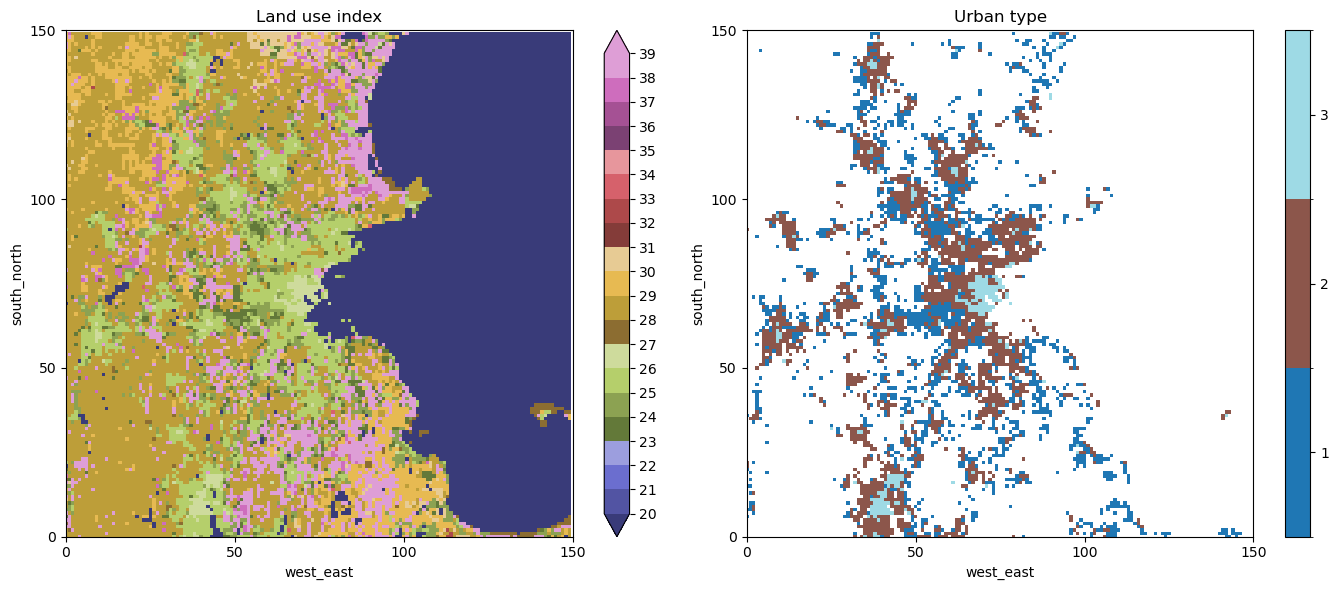

In [209]:
ds_ctl = datasets_ctl[folder_paths[0]]  # Access the control dataset for the first folder path

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot LU_INDEX at Time = 0 in the second panel
im1 = ds_ctl['LU_INDEX'].isel(Time=0).plot(ax=axes[0], cmap='tab20b', levels=list(range(20, 40)),
                                               cbar_kwargs={'label': '', 'ticks': list(range(20, 40))})
axes[0].set_title('Land use index')


# Plot UTYPE_URB at Time = 0 in the first panel
filtered_data = ds_ctl['UTYPE_URB'].where(ds_ctl['UTYPE_URB'] != 0)
im2 = filtered_data.isel(Time=0).plot(ax=axes[1], cmap='tab20', levels=[0.5, 1.5, 2.5, 3.5], extend='neither', cbar_kwargs={'label': ''})
axes[1].set_title('Urban type')

# Set x-axis limits and ticks for both subplots
for ax in axes:
    ax.set_xlim(0, 150)
    ax.set_xticks(list(range(0, 151, 50)))
    ax.set_ylim(0, 150)
    ax.set_yticks(list(range(0, 151, 50)))

# Get the colorbar and set custom ticks and labels
cbar = im2.colorbar
cbar.set_ticks([1, 2, 3])
cbar.set_ticklabels(['1', '2', '3'])

plt.tight_layout()
plt.show()
#fig.savefig(f"{folder_path}UTYPE.png", dpi=300)

## plot FRC_URB2D

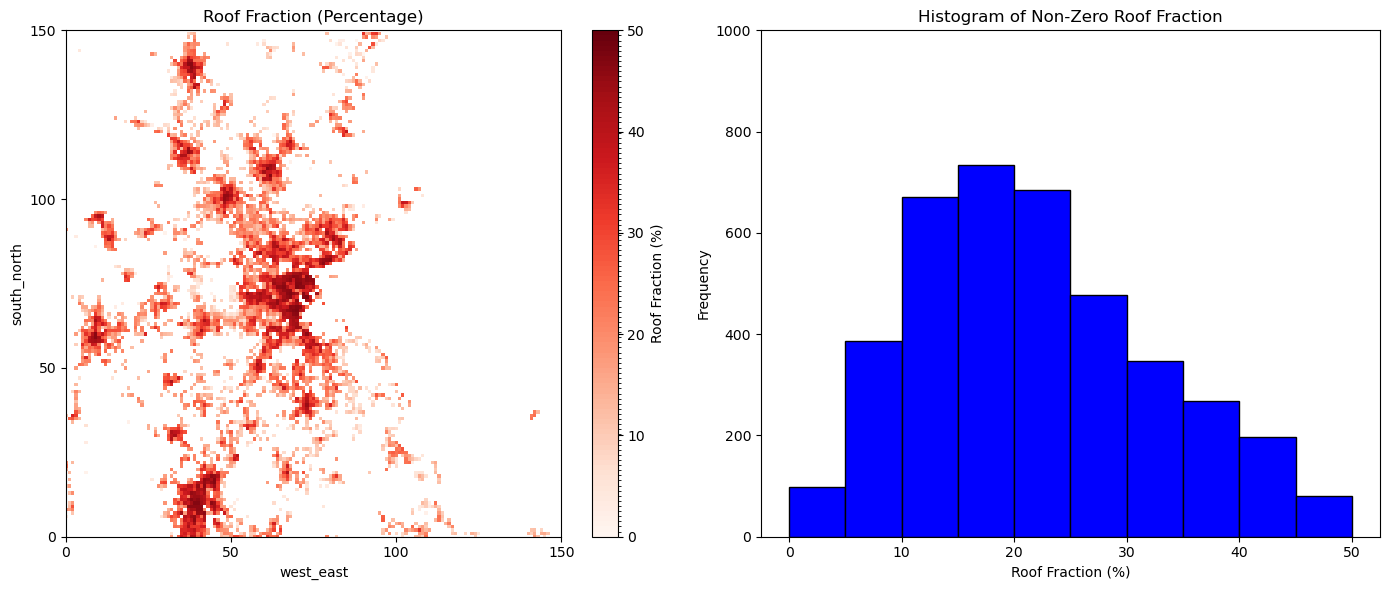

In [210]:
ds_ctl = datasets_ctl[folder_paths[0]]  # Access the control dataset for the first folder path

# Assuming ds_ctl is already defined and imported, and that UTYPE_URB is a variable in ds_ctl
# Create a figure with two subplots: one for the spatial pattern, one for the histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Extract and scale the FRC_URB2D data
FRC_ROOF = ds_ctl['FRC_URB2D'].where(ds_ctl['UTYPE_URB'] != 0) * 100 * 0.5

# Plot FRC_ROOF at Time=0 with a specified color axis range for the first subplot
im = FRC_ROOF.isel(Time=0).plot(ax=ax1, cmap='Reds', levels=100, vmin=0, vmax=50,
                                 cbar_kwargs={'ticks': list(range(0, 51, 10)), 'label': 'Roof Fraction (%)'})

ax1.set_title('Roof Fraction (Percentage)')

# Set x-axis and y-axis limits and ticks for the spatial pattern plot
ax1.set_xlim(0, 150)
ax1.set_xticks(list(range(0, 151, 50)))
ax1.set_ylim(0, 150)
ax1.set_yticks(list(range(0, 151, 50)))

# Define the bins from 0 to 50 in increments of 5
bins = np.arange(0, 55, 5)  # goes one step beyond 50 to include the last bin edge

# Plot the histogram for the non-zero FRC_URB2D data on the second subplot
ax2.hist(FRC_ROOF.isel(Time=0).values.flatten(), bins=bins, color='blue', edgecolor='black')
ax2.set_title('Histogram of Non-Zero Roof Fraction')
ax2.set_xlabel('Roof Fraction (%)')
ax2.set_ylabel('Frequency')
ax2.set_ylim(0, 1000)

plt.tight_layout()
plt.show()


## plot the spatial pattern of temporally averaged T2 between two cases


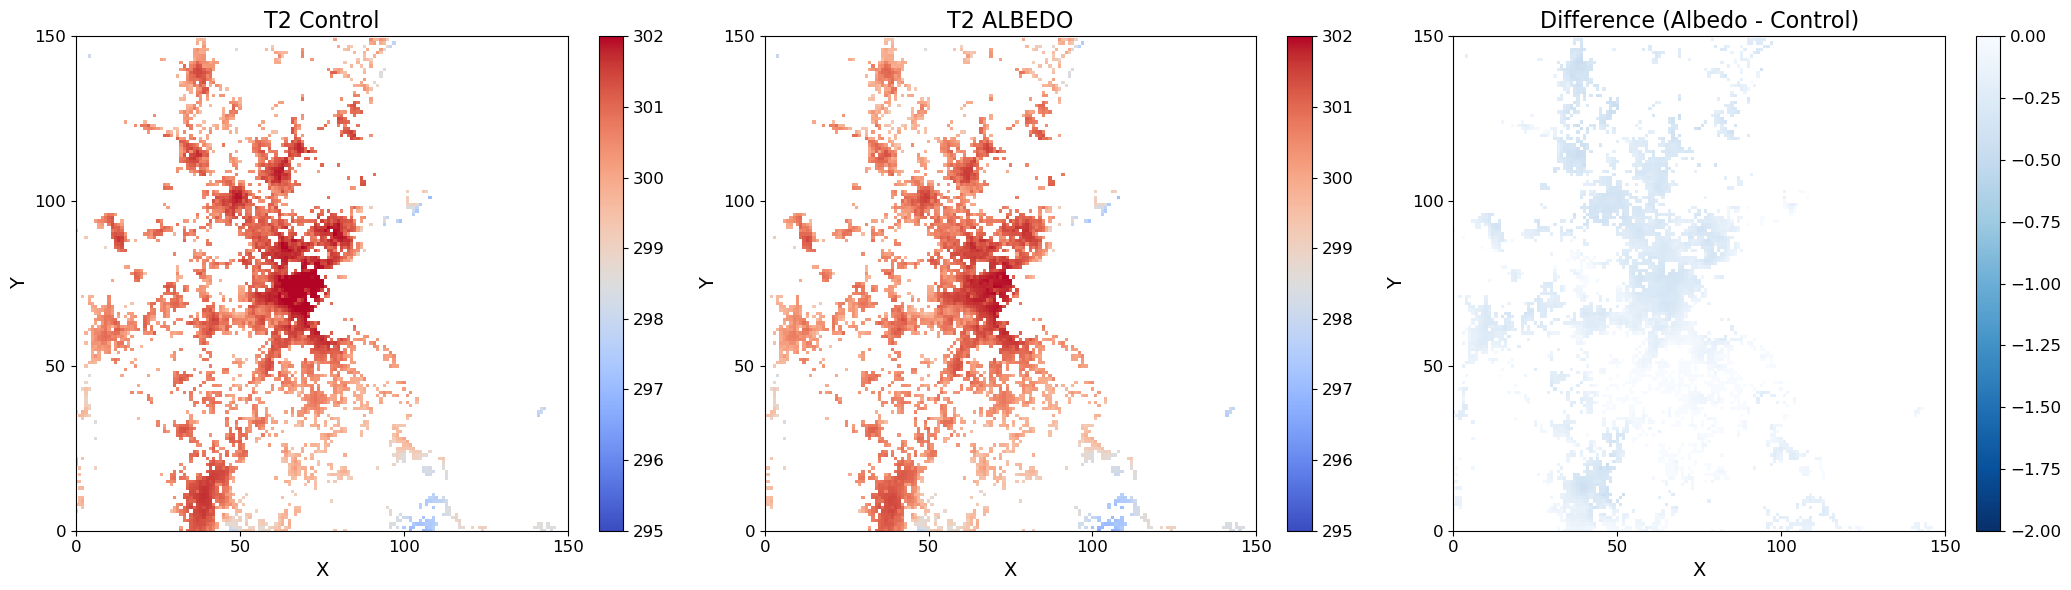

In [211]:
ds_ctl = datasets_ctl[folder_paths[0]]  # Access the control dataset for the first folder path
ds_alb = datasets_alb[folder_paths[0]]  # Access the albedo dataset for the first folder path

# Create three panels
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

T2_ctl = ds_ctl['T2'].where(ds_ctl['UTYPE_URB'] != 0)
T2_alb = ds_alb['T2'].where(ds_ctl['UTYPE_URB'] != 0)

# Compute the difference
T2_diff = T2_alb.mean(dim='Time') - T2_ctl.mean(dim='Time')

# Plot T2_ctl on ax1
im1 = T2_ctl.mean(dim='Time').plot(ax=ax1, cmap='coolwarm', vmin=295, vmax=302, add_colorbar=False)
ax1.set_title('T2 Control', fontsize=16)  # Adjust title font size
ax1.set_xlabel('X', fontsize=14)
ax1.set_ylabel('Y', fontsize=14)

# Plot T2_alb on ax2
im2 = T2_alb.mean(dim='Time').plot(ax=ax2, cmap='coolwarm', vmin=295, vmax=302, add_colorbar=False)
ax2.set_title('T2 ALBEDO', fontsize=16)  # Adjust title font size
ax2.set_xlabel('X', fontsize=14)
ax2.set_ylabel('Y', fontsize=14)

# Plot the difference on ax3
im3 = T2_diff.plot(ax=ax3, cmap='Blues_r', vmin=-2, vmax=0,  add_colorbar=False)
ax3.set_title('Difference (Albedo - Control)', fontsize=16)  # Adjust title font size
ax3.set_xlabel('X', fontsize=14)
ax3.set_ylabel('Y', fontsize=14)

# Add separate colorbars for each plot
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical')
cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical')
cbar3 = fig.colorbar(im3, ax=ax3, orientation='vertical')
cbar1.ax.tick_params(labelsize=12)
cbar2.ax.tick_params(labelsize=12)
cbar3.ax.tick_params(labelsize=12)

# Set axes limits and ticks for all plots
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(0, 150)
    ax.set_xticks(list(range(0, 151, 50)))
    ax.set_ylim(0, 150)
    ax.set_yticks(list(range(0, 151, 50)))
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()
# Save the figure
# fig.savefig(f"{folder_path}T2.png", dpi=300)

## plot the ACE 

Overall Maximum of T2: 0.23
Overall Minimum of T2: -0.48
The median of ACE is: 2.16
The mean of ACE is: 2.75
The range of ACE is from -12.122163352742383 to 684.0765679896284
num_valid_T2_values: 3944.00
num_valid_ACE_values: 3944.00


/var/folders/db/c54v0_4d5wb4gtcwcv819y2h0000gn/T/ipykernel_21195/1613352939.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


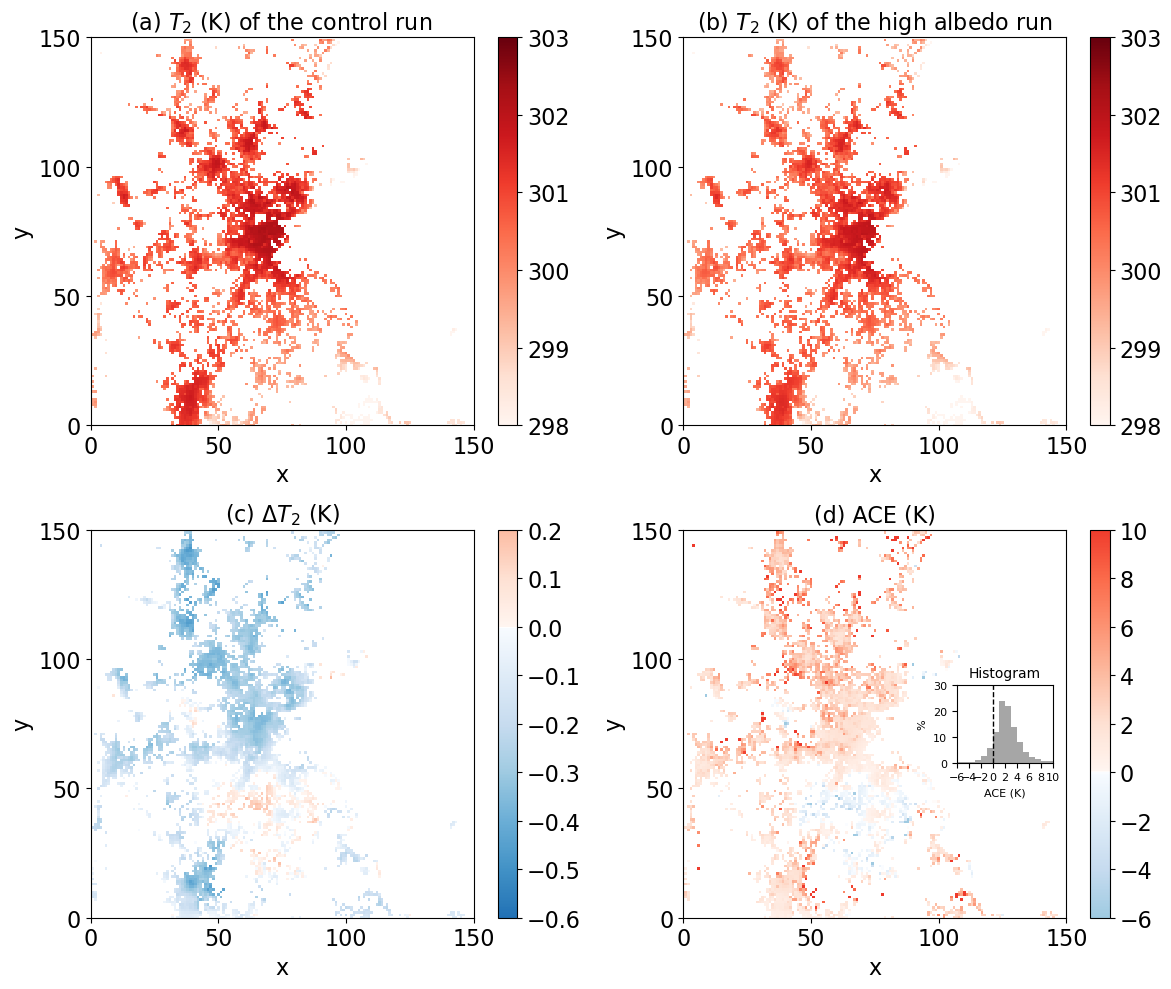

In [212]:
ds_ctl = datasets_ctl[folder_paths[0]]  # Access the control dataset for the second folder path
ds_alb = datasets_alb[folder_paths[0]]  # Access the albedo dataset for the second folder path

axis_label_font_size = 16
tick_label_font_size = 16
colorbar_tick_label_font_size = 16  # Adjust this to your desired size
title_font_size = 16

def create_colormap(vmin, vmax):
    # Calculate the proportion of the colorbar that should be blue (for negative values)
    total_range = vmax - vmin
    negative_proportion = abs(vmin) / total_range
    positive_proportion = 1 - negative_proportion
    
    # Define the starting point for the Reds and Blues_r to match the intensity
    blue_start = 1 - negative_proportion  # Blue will transition from light to dark across the negative range
    
    # Adjust red based on the positive proportion
    red_start = positive_proportion  # Red will transition from light to dark across the positive range
    
    # Sample colors from the Blues_r and Reds colormaps
    blues = plt.cm.Blues_r(np.linspace(1 - negative_proportion, 1.0, int(256 * negative_proportion)))  # Light to dark blue
    whites = np.array([1.0, 1.0, 1.0, 1.0]).reshape(1, 4)  # Pure white color in the middle
    reds = plt.cm.Reds(np.linspace(0, positive_proportion, int(256 * positive_proportion)))  # Adjust red transition based on positive proportion
    
    # Combine them into a single array
    colors = np.vstack((blues, whites, reds))
    
    # Create a new colormap
    cmap = LinearSegmentedColormap.from_list('CustomBluesReds', colors)
    
    return cmap

# Create four panels
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

T2_ctl = ds_ctl['T2'].where(ds_ctl['UTYPE_URB'] != 0)
T2_alb = ds_alb['T2'].where(ds_ctl['UTYPE_URB'] != 0)
Delta_ALBEDO = ds_ctl['Delta_ALBEDO_GRID'].where(ds_ctl['UTYPE_URB'] != 0)

# Compute the difference
T2_diff = T2_alb.mean(dim='Time') - T2_ctl.mean(dim='Time')

# Compute the overall maximum and minimum
overall_max = T2_diff.max(skipna=True)  # Maximum value
overall_min = T2_diff.min(skipna=True)  # Minimum value

# Retrieve the actual numerical values if using Dask
overall_max_value = overall_max.compute() if hasattr(overall_max, 'compute') else overall_max.values
overall_min_value = overall_min.compute() if hasattr(overall_min, 'compute') else overall_min.values

# Print results
print(f"Overall Maximum of T2: {overall_max_value:.2f}")
print(f"Overall Minimum of T2: {overall_min_value:.2f}")

albedo_diff = Delta_ALBEDO.mean(dim='Time')
ACE = -T2_diff / albedo_diff

ACE_computed = ACE.compute()  # Load data into memory
overall_median = ACE_computed.median(skipna=True)
overall_mean = ACE_computed.mean(skipna=True)
print(f"The median of ACE is: {overall_median.values:.2f}")
print(f"The mean of ACE is: {overall_mean.values:.2f}")

# Compute the min and max, ignoring NaN values
min_value = ACE_computed.min(skipna=True)
max_value = ACE_computed.max(skipna=True)

# Print the range
print(f"The range of ACE is from {min_value.values} to {max_value.values}")

# Plot T2_ctl on ax1
im1 = T2_ctl.mean(dim='Time').plot(ax=ax1, cmap='Reds', vmin=298, vmax=303, add_colorbar=False)
ax1.set_title('(a) $T_2$ (K) of the control run ',fontsize=title_font_size)

# Plot T2_alb on ax2
im2 = T2_alb.mean(dim='Time').plot(ax=ax2, cmap='Reds', vmin=298, vmax=303, add_colorbar=False)
ax2.set_title('(b) $T_2$ (K) of the high albedo run',fontsize=title_font_size)

# Define vmin and vmax for the custom colormap
vmin = -0.6
vmax = 0.2
custom_cmap = create_colormap(vmin, vmax)
norm = matplotlib.colors.Normalize(vmin, vmax)

# Plot the difference on ax3
im3 = T2_diff.plot(ax=ax3, cmap=custom_cmap, norm=norm, add_colorbar=False)
ax3.set_title('(c) $\Delta T_2$ (K)',fontsize=title_font_size)

# Define vmin and vmax for the custom colormap
vmin = -6
vmax = 10
custom_cmap = create_colormap(vmin, vmax)
norm = matplotlib.colors.Normalize(vmin, vmax)

# Plot ACE on ax4 (make sure ACE is 2D)
im4 = ACE.plot(ax=ax4, cmap=custom_cmap, norm=norm,  add_colorbar=False)
ax4.set_title('(d) ACE (K)',fontsize=title_font_size)

# Add an inset axis for the histogram on ax4
inset_ax = inset_axes(ax4, width="25%", height="20%", 
                      loc="center right",  # Position the inset inside the plot
                      borderpad=1)

# Plot the histogram of ACE on the inset axis, with bins from 0 to 10, and 20 bins
ACE_values = ACE.values.flatten()  # Flatten the 2D array to 1D for histogram

# Calculate the number of grid cells where UTYPE_URB != 0 and compute the result
valid_T2 = ds_ctl['T2'].where(ds_ctl['UTYPE_URB'] != 0).mean(dim='Time')
num_valid_T2_values = valid_T2.count().compute().item()
print(f"num_valid_T2_values: {num_valid_T2_values:.2f}")    

# Number of non-NaN values in ACE
num_valid_ACE_values = np.count_nonzero(~np.isnan(ACE.values))
print(f"num_valid_ACE_values: {num_valid_ACE_values:.2f}")    


# Plot the histogram of ACE on the inset axis
hist_values, bins, _ = inset_ax.hist(ACE_values, bins=20, range=(-10, 10), 
                                     color='gray', alpha=0.7, density=False)  # `density=False` to get the counts

# Normalize the histogram by dividing the counts by the number of valid grid cells
#print(hist_values)
hist_values_normalized = hist_values / num_valid_ACE_values *100

# Clear the inset axis and replot the normalized histogram
inset_ax.clear()
inset_ax.bar(bins[:-1], hist_values_normalized, width=np.diff(bins), align='edge', color='gray', alpha=0.7)

inset_ax.set_title("Histogram", fontsize=10)

# Set the x and y limits of the inset histogram
inset_ax.set_xlim(-6, 10)
inset_ax.set_ylim(0, 30)  # Adjust the y-limit to fit the normalized values
inset_ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
inset_ax.set_xlabel('ACE (K)', fontsize=8)
inset_ax.set_ylabel('%', fontsize=8)
# Set the x-ticks and tick parameters
inset_ax.set_xticks(list(range(-6, 11, 2)))
inset_ax.tick_params(axis='both', which='major', labelsize=8)



# Add separate colorbars for each plot
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical')
cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical')
cbar3 = fig.colorbar(im3, ax=ax3, orientation='vertical')
cbar4 = fig.colorbar(im4, ax=ax4, orientation='vertical')
# Set the font size of the colorbar ticks
cbar1.ax.tick_params(labelsize=colorbar_tick_label_font_size)
cbar2.ax.tick_params(labelsize=colorbar_tick_label_font_size)
cbar3.ax.tick_params(labelsize=colorbar_tick_label_font_size)
cbar4.ax.tick_params(labelsize=colorbar_tick_label_font_size)

# Set axes limits and ticks for all plots
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(0, 150)
    ax.set_xticks(list(range(0, 151, 50)))
    ax.set_ylim(0, 150)
    ax.set_yticks(list(range(0, 151, 50)))
    ax.set_xlabel('x', fontsize=axis_label_font_size)
    ax.set_ylabel('y', fontsize=axis_label_font_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig("figures/T2.png", dpi=300)

## plot the ACE for roof surface temperature 

num_valid_T2_values: 3944.00
num_valid_ACE_values: 3944.00


/var/folders/db/c54v0_4d5wb4gtcwcv819y2h0000gn/T/ipykernel_21195/829953617.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


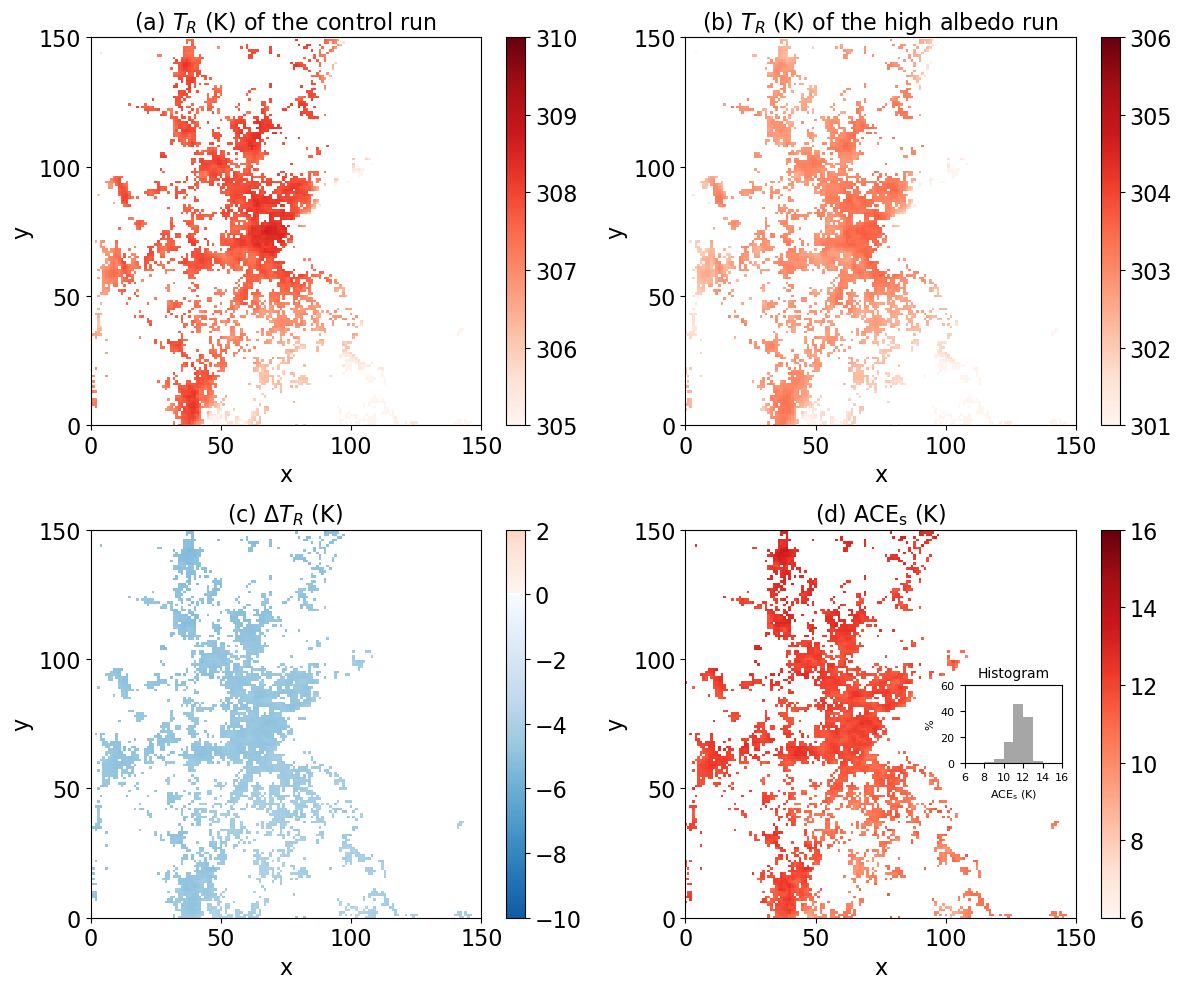

In [213]:
ds_ctl = datasets_ctl[folder_paths[0]]  # Access the control dataset for the first folder path
ds_alb = datasets_alb[folder_paths[0]]  # Access the albedo dataset for the first folder path

axis_label_font_size = 16
tick_label_font_size = 16
colorbar_tick_label_font_size = 16  # Adjust this to your desired size
title_font_size = 16

def create_colormap(vmin, vmax):
    # Calculate the proportion of the colorbar that should be blue (for negative values)
    total_range = vmax - vmin
    negative_proportion = abs(vmin) / total_range
    positive_proportion = 1 - negative_proportion
    
    # Define the starting point for the Reds and Blues_r to match the intensity
    blue_start = 1 - negative_proportion  # Blue will transition from light to dark across the negative range
    
    # Adjust red based on the positive proportion
    red_start = positive_proportion  # Red will transition from light to dark across the positive range
    
    # Sample colors from the Blues_r and Reds colormaps
    blues = plt.cm.Blues_r(np.linspace(1 - negative_proportion, 1.0, int(256 * negative_proportion)))  # Light to dark blue
    whites = np.array([1.0, 1.0, 1.0, 1.0]).reshape(1, 4)  # Pure white color in the middle
    reds = plt.cm.Reds(np.linspace(0, positive_proportion, int(256 * positive_proportion)))  # Adjust red transition based on positive proportion
    
    # Combine them into a single array
    colors = np.vstack((blues, whites, reds))
    
    # Create a new colormap
    cmap = LinearSegmentedColormap.from_list('CustomBluesReds', colors)
    
    return cmap

# Create four panels
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

T2_ctl = ds_ctl['TR_URB'].where(ds_ctl['UTYPE_URB'] != 0)
T2_alb = ds_alb['TR_URB'].where(ds_ctl['UTYPE_URB'] != 0)
Delta_ALBEDO = ds_ctl['Delta_ALBEDO_ROOF'].where(ds_ctl['UTYPE_URB'] != 0)

# Compute the difference
T2_diff = T2_alb.mean(dim='Time') - T2_ctl.mean(dim='Time')
albedo_diff = Delta_ALBEDO.mean(dim='Time')
ACE = -T2_diff / albedo_diff

# Plot T2_ctl on ax1
im1 = T2_ctl.mean(dim='Time').plot(ax=ax1, cmap='Reds', vmin=305, vmax=310, add_colorbar=False)
ax1.set_title('(a) $T_R$ (K) of the control run',fontsize=title_font_size)

# Plot T2_alb on ax2
im2 = T2_alb.mean(dim='Time').plot(ax=ax2, cmap='Reds', vmin=301, vmax=306, add_colorbar=False)
ax2.set_title('(b) $T_R$ (K) of the high albedo run',fontsize=title_font_size)

# Define vmin and vmax for the custom colormap
vmin = -10
vmax = 2
custom_cmap = create_colormap(vmin, vmax)
norm = matplotlib.colors.Normalize(vmin, vmax)

# Plot the difference on ax3
im3 = T2_diff.plot(ax=ax3, cmap=custom_cmap, norm=norm, add_colorbar=False)
ax3.set_title('(c) $\Delta T_R$ (K) ',fontsize=title_font_size)

# Define vmin and vmax for the custom colormap
# vmin = 6
# vmax = 16
# custom_cmap = create_colormap(vmin, vmax)
# norm = matplotlib.colors.Normalize(vmin, vmax)

# Plot ACE on ax4 (make sure ACE is 2D)
im4 = ACE.plot(ax=ax4, cmap='Reds', vmin = 6, vmax = 16, add_colorbar=False)
ax4.set_title('(d) $\mathrm{ACE_s}$ (K)',fontsize=title_font_size)

# Add an inset axis for the histogram on ax4
inset_ax = inset_axes(ax4, width="25%", height="20%", 
                      loc="center right",  # Position the inset inside the plot
                      borderpad=1)

# Plot the histogram of ACE on the inset axis, with bins from 0 to 10, and 20 bins
ACE_values = ACE.values.flatten()  # Flatten the 2D array to 1D for histogram
# Plot the histogram of ACE on the inset axis, with bins from 0 to 10, and 20 bins
# Calculate the number of grid cells where UTYPE_URB != 0 and compute the result
valid_T2 = ds_ctl['T2'].where(ds_ctl['UTYPE_URB'] != 0).mean(dim='Time')
num_valid_T2_values = valid_T2.count().compute().item()
print(f"num_valid_T2_values: {num_valid_T2_values:.2f}")    
# Number of non-NaN values in ACE
num_valid_ACE_values = np.count_nonzero(~np.isnan(ACE.values))
print(f"num_valid_ACE_values: {num_valid_ACE_values:.2f}")    


# Plot the histogram of ACE on the inset axis
hist_values, bins, _ = inset_ax.hist(ACE_values, bins=20, range=(0, 20), 
                                     color='gray', alpha=0.7, density=False)  # `density=False` to get the counts

# Normalize the histogram by dividing the counts by the number of valid grid cells
#print(hist_values)
hist_values_normalized = hist_values / num_valid_ACE_values *100

# Clear the inset axis and replot the normalized histogram
inset_ax.clear()
inset_ax.bar(bins[:-1], hist_values_normalized, width=np.diff(bins), align='edge', color='gray', alpha=0.7)

inset_ax.set_title("Histogram", fontsize=10)


# Adjust the x-axis limits of the histogram to match the range
inset_ax.set_xlim(6, 16)
inset_ax.set_ylim(0, 60)
inset_ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
inset_ax.set_xticks(list(range(6, 17, 2)))
inset_ax.set_xlabel('$\mathrm{ACE_s}$ (K)', fontsize=8)
inset_ax.set_ylabel('%', fontsize=8)
# Set the x-ticks and tick parameters
inset_ax.tick_params(axis='both', which='major', labelsize=8)

# Add separate colorbars for each plot
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical')
cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical')
cbar3 = fig.colorbar(im3, ax=ax3, orientation='vertical')
cbar4 = fig.colorbar(im4, ax=ax4, orientation='vertical')
# Set the font size of the colorbar ticks
cbar1.ax.tick_params(labelsize=colorbar_tick_label_font_size)
cbar2.ax.tick_params(labelsize=colorbar_tick_label_font_size)
cbar3.ax.tick_params(labelsize=colorbar_tick_label_font_size)
cbar4.ax.tick_params(labelsize=colorbar_tick_label_font_size)

# Set axes limits and ticks for all plots
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(0, 150)
    ax.set_xticks(list(range(0, 151, 50)))
    ax.set_ylim(0, 150)
    ax.set_yticks(list(range(0, 151, 50)))
    ax.set_xlabel('x', fontsize=axis_label_font_size)
    ax.set_ylabel('y', fontsize=axis_label_font_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig("figures/TR.png", dpi=300)

3944
3944


/var/folders/db/c54v0_4d5wb4gtcwcv819y2h0000gn/T/ipykernel_21195/557097377.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


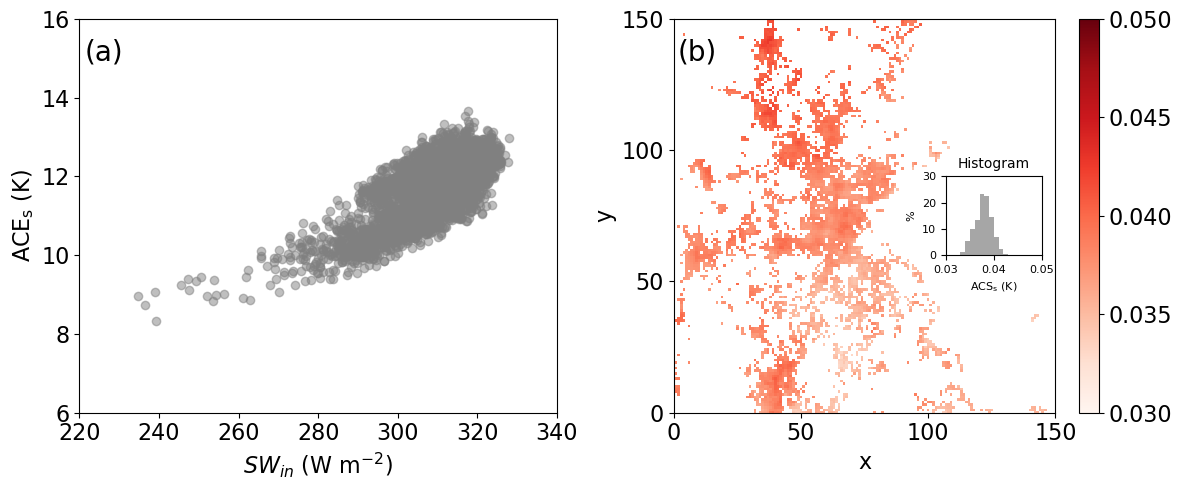

In [214]:
ds_ctl = datasets_ctl[folder_paths[0]]  # Access the control dataset for the first folder path
ds_alb = datasets_alb[folder_paths[0]]  # Access the albedo dataset for the first folder path

axis_label_font_size = 16
tick_label_font_size = 16
colorbar_tick_label_font_size = 16  # Adjust this to your desired size
title_font_size = 16

def create_colormap(vmin, vmax):
    # Calculate the proportion of the colorbar that should be blue (for negative values)
    total_range = vmax - vmin
    negative_proportion = abs(vmin) / total_range
    positive_proportion = 1 - negative_proportion
    
    # Define the starting point for the Reds and Blues_r to match the intensity
    blue_start = 1 - negative_proportion  # Blue will transition from light to dark across the negative range
    
    # Adjust red based on the positive proportion
    red_start = positive_proportion  # Red will transition from light to dark across the positive range
    
    # Sample colors from the Blues_r and Reds colormaps
    blues = plt.cm.Blues_r(np.linspace(1 - negative_proportion, 1.0, int(256 * negative_proportion)))  # Light to dark blue
    whites = np.array([1.0, 1.0, 1.0, 1.0]).reshape(1, 4)  # Pure white color in the middle
    reds = plt.cm.Reds(np.linspace(0, positive_proportion, int(256 * positive_proportion)))  # Adjust red transition based on positive proportion
    
    # Combine them into a single array
    colors = np.vstack((blues, whites, reds))
    
    # Create a new colormap
    cmap = LinearSegmentedColormap.from_list('CustomBluesReds', colors)
    
    return cmap

# Create four panels
fig, (ax2, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Add labels (a), (b), (c), (d) to the top-left corner of each subplot
ax2.text(0.01, 0.95, '(a)', transform=ax2.transAxes, fontsize=20, verticalalignment='top')
ax4.text(0.01, 0.95, '(b)', transform=ax4.transAxes, fontsize=20, verticalalignment='top')

T2_ctl = ds_ctl['T2'].where(ds_ctl['UTYPE_URB'] != 0)
T2_alb = ds_alb['T2'].where(ds_ctl['UTYPE_URB'] != 0)

TR_ctl = ds_ctl['TR_URB'].where(ds_ctl['UTYPE_URB'] != 0)
TR_alb = ds_alb['TR_URB'].where(ds_ctl['UTYPE_URB'] != 0)
Delta_ALBEDO = ds_ctl['Delta_ALBEDO_ROOF'].where(ds_ctl['UTYPE_URB'] != 0)
FORCING_ROOF = ds_ctl['FORCING_ROOF'].where(ds_ctl['UTYPE_URB'] != 0)
SWDOWN = ds_ctl['SWDOWN'].where(ds_ctl['UTYPE_URB'] != 0)

# Compute the difference
T2_diff = T2_alb.mean(dim='Time') - T2_ctl.mean(dim='Time')
TR_diff = TR_alb.mean(dim='Time') - TR_ctl.mean(dim='Time')
albedo_diff = Delta_ALBEDO.mean(dim='Time')
FORCING_ROOF_diff = FORCING_ROOF.mean(dim='Time')
SWDOWN_diff = SWDOWN.mean(dim='Time')

# Compute the difference
ACE = -T2_diff / albedo_diff
ACE_s = -TR_diff / albedo_diff
ACS_s = -TR_diff / FORCING_ROOF_diff


# ACS_computed = ACS_s.compute()  # Load data into memory
# overall_median = ACS_computed.median(skipna=True)
# overall_mean = ACS_computed.mean(skipna=True)
# print(overall_median)
# print(overall_mean)

# Plot the difference on ax3
ax2.scatter(SWDOWN_diff.values.flatten(),ACE_s.values.flatten(), marker='o', alpha=0.5, color='grey')  # Customize marker and color
#ax2.set_title('(c) $\Delta T_R$ (K) ',fontsize=title_font_size)

ax2.set_xlim(220, 340)
ax2.set_ylim(6, 16)
ax2.set_xlabel('$SW_{in}$ (W m$^{-2}$)', fontsize=axis_label_font_size)
ax2.set_ylabel('$\mathrm{ACE_s}$ (K)', fontsize=axis_label_font_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_label_font_size)

# Add a linear line to the scatter plot
# x_values = np.linspace(200, 400, 20)
# y_values = 0.038*x_values 
# ax2.plot(x_values, y_values, color='black', linestyle='-', linewidth=2)



# Plot ACE on ax4 (make sure ACE is 2D)
im4 = ACS_s.plot(ax=ax4, cmap='Reds', vmin = 0.03, vmax = 0.05, add_colorbar=False)
#ax4.set_title('$\mathrm{ACS_s}$ (K)',fontsize=title_font_size)

# Add an inset axis for the histogram on ax4
inset_ax = inset_axes(ax4, width="25%", height="20%", 
                      loc="center right",  # Position the inset inside the plot
                      borderpad=1)

# Plot the histogram of ACE on the inset axis, with bins from 0 to 10, and 20 bins
ACS_values = ACS_s.values.flatten()  # Flatten the 2D array to 1D for histogram
# Plot the histogram of ACE on the inset axis, with bins from 0 to 10, and 20 bins
# Calculate the number of grid cells where UTYPE_URB != 0 and compute the result
valid_T2 = ds_ctl['T2'].where(ds_ctl['UTYPE_URB'] != 0).mean(dim='Time')
num_valid_T2_values = valid_T2.count().compute().item()
print(num_valid_T2_values)
# Number of non-NaN values in ACE
num_valid_ACE_values = np.count_nonzero(~np.isnan(ACE.values))
print(num_valid_ACE_values)

# Plot the histogram of ACE on the inset axis
hist_values, bins, _ = inset_ax.hist(ACS_values, bins=20, range=(0.03, 0.05), 
                                     color='gray', alpha=0.7, density=False)  # `density=False` to get the counts

# Normalize the histogram by dividing the counts by the number of valid grid cells
#print(hist_values)
hist_values_normalized = hist_values / num_valid_ACE_values *100

# Clear the inset axis and replot the normalized histogram
inset_ax.clear()
inset_ax.bar(bins[:-1], hist_values_normalized, width=np.diff(bins), align='edge', color='gray', alpha=0.7)

inset_ax.set_title("Histogram", fontsize=10)


# Adjust the x-axis limits of the histogram to match the range
inset_ax.set_xlim(0.03, 0.05)
inset_ax.set_ylim(0, 30)
inset_ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
inset_ax.set_xticks(np.arange(0.03, 0.05, 0.01))
inset_ax.set_xlabel('$\mathrm{ACS_s}$ (K)', fontsize=8)
inset_ax.set_ylabel('%', fontsize=8)
# Set the x-ticks and tick parameters
inset_ax.tick_params(axis='both', which='major', labelsize=8)

# Add separate colorbars for each plot
# cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical')
# cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical')
# cbar3 = fig.colorbar(im3, ax=ax3, orientation='vertical')
cbar4 = fig.colorbar(im4, ax=ax4, orientation='vertical')
# Set the font size of the colorbar ticks
# cbar1.ax.tick_params(labelsize=colorbar_tick_label_font_size)
# cbar2.ax.tick_params(labelsize=colorbar_tick_label_font_size)
# cbar3.ax.tick_params(labelsize=colorbar_tick_label_font_size)
cbar4.ax.tick_params(labelsize=colorbar_tick_label_font_size)

# Set axes limits and ticks for all plots
for ax in [ax4]:
    ax.set_xlim(0, 150)
    ax.set_xticks(list(range(0, 151, 50)))
    ax.set_ylim(0, 150)
    ax.set_yticks(list(range(0, 151, 50)))
    ax.set_xlabel('x', fontsize=axis_label_font_size)
    ax.set_ylabel('y', fontsize=axis_label_font_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)


plt.tight_layout()
plt.show()

# Save the figure
fig.savefig("figures/ACS.png", dpi=300)

## attribution of T2 (caluclation)

In [215]:
#%%

def compute_T2_URB_DIAG_TC_NOT_INCLUDED(ds, TS_RUL=None, TR_URB=None, TB_URB=None, TG_URB=None, TA_URB=None, ALPHAR_URB2D=None, ALPHAB_URB2D=None, ALPHAG_URB2D=None, ALPHAC_URB2D=None, AH=None, CHS_URB2D=None, CHS2_URB2D=None, Q_RUL=None):
    # Use the provided replacements if available or default to dataset values
    TS_RUL = ds['TS_RUL'] if TS_RUL is None else TS_RUL
    TR_URB = ds['TR_URB'] if TR_URB is None else TR_URB
    TB_URB = ds['TB_URB'] if TB_URB is None else TB_URB
    TG_URB = ds['TG_URB'] if TG_URB is None else TG_URB
    TA_URB = ds['TA_URB'] if TA_URB is None else TA_URB
    ALPHAR_URB2D = ds['ALPHAR_URB2D'] if ALPHAR_URB2D is None else ALPHAR_URB2D
    ALPHAB_URB2D = ds['ALPHAB_URB2D'] if ALPHAB_URB2D is None else ALPHAB_URB2D
    ALPHAG_URB2D = ds['ALPHAG_URB2D'] if ALPHAG_URB2D is None else ALPHAG_URB2D
    ALPHAC_URB2D = ds['ALPHAC_URB2D'] if ALPHAC_URB2D is None else ALPHAC_URB2D
    CHS_URB2D = ds['CHS_URB2D'] if CHS_URB2D is None else CHS_URB2D
    CHS2_URB2D = ds['CHS2_URB2D'] if CHS2_URB2D is None else CHS2_URB2D
    Q_RUL = ds['Q_RUL'] if Q_RUL is None else Q_RUL
    AH = 0 if AH is None else AH

    # # Check if any variable is None after attempting to get from ds
    # if any(v is None for v in [TS_RUL, TR_URB, TB_URB, TG_URB, TA_URB, ALPHAR_URB2D, ALPHAB_URB2D, ALPHAG_URB2D, ALPHAC_URB2D, CHS_URB2D, CHS2_URB2D, Q_RUL]):
    #     raise ValueError("One or more required variables are missing from the dataset.")

    TC_URB = (ds['RW_TBL']*TA_URB*ALPHAC_URB2D + \
                    ds['RW_TBL']*TG_URB*ALPHAG_URB2D + \
                    ds['W_TBL']*TB_URB*ALPHAB_URB2D + AH*converstion_factor) / \
                  (ds['RW_TBL']*ALPHAC_URB2D + 
                    ds['RW_TBL']*ALPHAG_URB2D + 
                    ds['W_TBL']*ALPHAB_URB2D)
                  
    T2_URB_DIAG = (TS_RUL * (1 - ds['FRC_URB2D']) + 
                    ((ds['R_TBL'] * (TR_URB - TA_URB) * ALPHAR_URB2D / converstion_factor + 
                      ds['W_TBL'] * (TB_URB - TC_URB) * ALPHAB_URB2D / converstion_factor + 
                      ds['RW_TBL'] * (TG_URB - TC_URB) * ALPHAG_URB2D / converstion_factor + 
                      AH) / CHS_URB2D + TA_URB) * ds['FRC_URB2D']) - \
                    ((Q_RUL * (1 - ds['FRC_URB2D']) + 
                      (ds['R_TBL'] * (TR_URB - TA_URB) * ALPHAR_URB2D / converstion_factor + 
                      ds['W_TBL'] * (TB_URB - TC_URB) * ALPHAB_URB2D / converstion_factor + 
                      ds['RW_TBL'] * (TG_URB - TC_URB) * ALPHAG_URB2D / converstion_factor + 
                      AH) * ds['FRC_URB2D']) / CHS2_URB2D)
               
    # T2_URB_DIAG = (TS_RUL * (1 - ds['FRC_URB2D']) + 
    #                 ((ds['R_TBL'] * (TR_URB - TA_URB) * ALPHAR_URB2D / converstion_factor + 
    #                   ds['W_TBL'] * (TB_URB - TC_URB) * ALPHAB_URB2D / converstion_factor + 
    #                   ds['RW_TBL'] * (TG_URB - TC_URB) * ALPHAG_URB2D / converstion_factor + 
    #                   AH) / CHS_URB2D + TA_URB) * ds['FRC_URB2D']) - \
    #                 (((TS_RUL-TA_URB)*CHS_URB2D * (1 - ds['FRC_URB2D']) + 
    #                   (ds['R_TBL'] * (TR_URB - TA_URB) * ALPHAR_URB2D / converstion_factor + 
    #                   ds['W_TBL'] * (TB_URB - TC_URB) * ALPHAB_URB2D / converstion_factor + 
    #                   ds['RW_TBL'] * (TG_URB - TC_URB) * ALPHAG_URB2D / converstion_factor + 
    #                   AH) * ds['FRC_URB2D']) / CHS2_URB2D)
    return T2_URB_DIAG





In [216]:
#%% 
decomposed_values = {}
decomposed_std_dev = {}
utypes = ["all", 1, 2, 3]

ds_ctl = datasets_ctl[folder_paths[0]]  # Access the control dataset for the first folder path
ds_alb = datasets_alb[folder_paths[0]]  # Access the albedo dataset for the first folder path

# Iterate over urban types (e.g., all, 1, 2, 3)
for utype in utypes:
    if utype == "all":
        folder_1_filtered = ds_ctl
    else:
        folder_1_filtered = ds_ctl.where(ds_ctl['UTYPE_URB'] == utype)

    # Calculate baseline time average for T2_URB_DIAG in the control dataset
    folder_1_ts_urb_diag_baseline_time_avg = folder_1_filtered['T2_URB_DIAG'].mean(dim='Time') 
    albedo_diff = folder_1_filtered['Delta_ALBEDO_GRID'].mean(dim='Time')
    
    # For the albedo dataset (ds_alb)
    if utype == "all":
        ds_filtered = ds_alb
    else:
        ds_filtered = ds_alb.where(ds_alb['UTYPE_URB'] == utype)

    results = []
    std_devs = []

    # Compute the T2_URB_DIAG using different parameter sets
    for compute_func, params in [
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TR_URB": ds_filtered['TR_URB']}),
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TA_URB": ds_filtered['TA_URB']}),
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TB_URB": ds_filtered['TB_URB'], "TG_URB": ds_filtered['TG_URB']}), 
            (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TS_RUL": ds_filtered['TS_RUL'],"Q_RUL": ds_filtered['Q_RUL']}),       
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"ALPHAR_URB2D": ds_filtered['ALPHAR_URB2D'], "ALPHAB_URB2D": ds_filtered['ALPHAB_URB2D'], "ALPHAG_URB2D": ds_filtered['ALPHAG_URB2D'], "ALPHAC_URB2D": ds_filtered['ALPHAC_URB2D'], "CHS_URB2D": ds_filtered['CHS_URB2D'], "CHS2_URB2D": ds_filtered['CHS2_URB2D']})        
    ]:
        # Calculate the difference in time averages between albedo and control datasets
        diff_time_avg = (compute_func(folder_1_filtered, **params).mean(dim='Time') - folder_1_ts_urb_diag_baseline_time_avg)
        spatial_avg_diff = diff_time_avg.mean(['south_north', 'west_east']).values
        spatial_std_dev = diff_time_avg.std(['south_north', 'west_east']).values

        results.append(spatial_avg_diff)
        std_devs.append(spatial_std_dev)

    # Compute the overall time-averaged difference for the albedo dataset
    overall_diff_time_avg = ds_filtered['T2_URB_DIAG'].mean(dim='Time') 
    overall_spatial_avg_diff = ((overall_diff_time_avg - folder_1_ts_urb_diag_baseline_time_avg)).mean(['south_north', 'west_east']).values
    overall_spatial_std_dev = ((overall_diff_time_avg - folder_1_ts_urb_diag_baseline_time_avg)).std(['south_north', 'west_east']).values
    
    # Cumulative sum of results and standard deviations
    cumulative_sum = sum(results)
    cumulative_sum_std_dev = np.sqrt(sum([std_dev**2 for std_dev in std_devs]))

    # Store the results for each urban type
    decomposed_values[(utype)] = [overall_spatial_avg_diff, cumulative_sum] + results
    decomposed_std_dev[(utype)] = [overall_spatial_std_dev, cumulative_sum_std_dev] + std_devs

## validate T2 calculation 

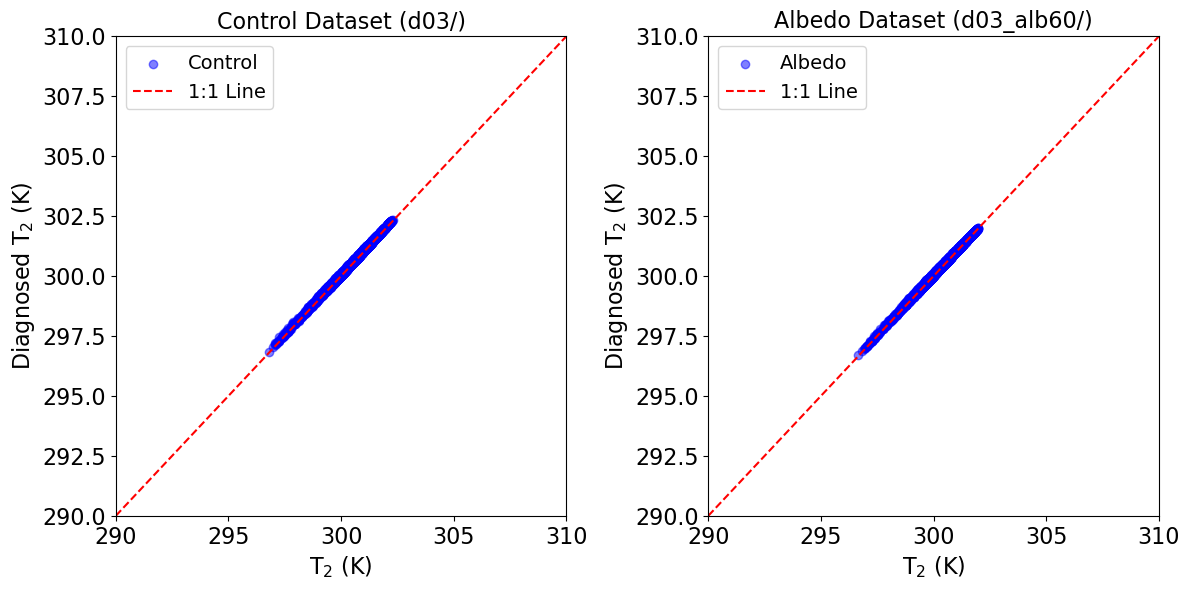

In [217]:
# Create a 1x2 grid of subplots (one for control and one for albedo)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes = axes.flatten()  # Flatten to make indexing easier

# Titles for control and albedo datasets
titles = ["Control Dataset (d03/)", "Albedo Dataset (d03_alb60/)"]

# Access control and albedo datasets from the dictionaries
ds_ctl, ds_alb = datasets_ctl[folder_paths[0]], datasets_alb[folder_paths[0]]


# List of datasets and labels for iteration
datasets = [("Control", ds_ctl), ("Albedo", ds_alb)]

# Iterate over control and albedo datasets to plot them
for i, (label, ds) in enumerate(datasets):
    ax = axes[i]  # Select the appropriate subplot

    # Scatter plot of T2 vs Diagnosed T2
    ax.scatter(ds['t2_urb_avg_time'].values.flatten(),
               ds['t2_urb_diag_avg_time'].values.flatten(),
               marker='o', alpha=0.5, label=f"{label}", color='blue')  # Customize marker and color

    # Add 1:1 line for reference
    ax.plot([290, 310], [290, 310], 'r--', label="1:1 Line")  # Red dashed line for 1:1 line
    
    # Set axis limits and labels
    ax.set_xlim([290, 310])
    ax.set_ylim([290, 310])
    ax.set_xlabel("T$_2$ (K)", fontsize=axis_label_font_size)
    ax.set_ylabel("Diagnosed T$_2$ (K)", fontsize=axis_label_font_size)
    
    # Set title for the subplot
    ax.set_title(titles[i], fontsize=title_font_size)
    
    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)

    # Add legend to the subplot
    ax.legend(fontsize=legend_font_size)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Save the figure
# fig.savefig("T2_figures/validation_T2_ctl_vs_alb.png", dpi=300)

## attribution of T2 (plot)

/var/folders/db/c54v0_4d5wb4gtcwcv819y2h0000gn/T/ipykernel_21195/3352237006.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, ha="right")  # Added ha="right" for better label alignment
/var/folders/db/c54v0_4d5wb4gtcwcv819y2h0000gn/T/ipykernel_21195/3352237006.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, ha="right")  # Added ha="right" for better label alignment
/var/folders/db/c54v0_4d5wb4gtcwcv819y2h0000gn/T/ipykernel_21195/3352237006.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, ha="right")  # Added ha="right" for better label alignment
/var/folders/db/c54v0_4d5wb4gtcwcv819y2h0000gn/T/ipykernel_21195/3352237006.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, ha="right")  # Added ha

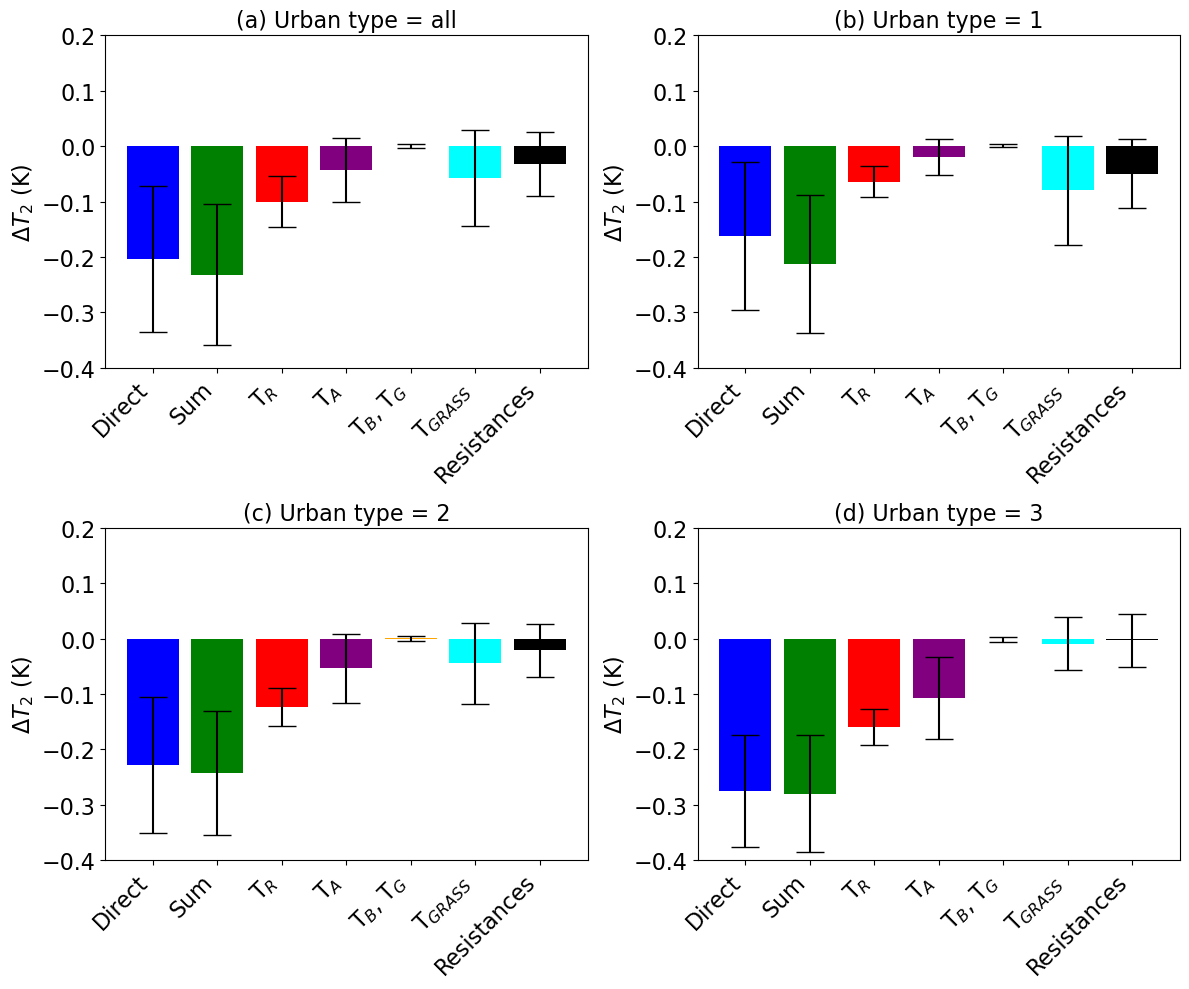

In [218]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Setting up a 4x3 grid
axes = axes.ravel()  # Flattening the axes to easily index them

labels = ["Direct", "Sum", "T$_R$", "T$_A$", "T$_B$, T$_G$", "T$_{GRASS}$", "Resistances"]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'black']

subplot_labels = [f'({chr(97 + i)})' for i in range(12)]  # Generates labels (a), (b), ..., (l)

for idx, (utype, values) in enumerate(decomposed_values.items()):
    ax = axes[idx]
    
    # Fetch the standard deviations for the current utype
    std_devs = decomposed_std_dev[utype]
    
    # Plot bar chart with error bars
    ax.bar(labels, values, color=colors[:len(labels)], yerr=std_devs, capsize=10)  # Added yerr for error bars and capsize for cap size on error bars
    
    # Set title using subplot labels and utype
    ax.set_title(f'{subplot_labels[idx]} Urban type = {utype}', fontsize=title_font_size)
    
    # Customize x-axis labels
    ax.set_xticklabels(labels, rotation=45, ha="right")  # Added ha="right" for better label alignment
    ax.set_ylim(-0.4, 0.2)  # Set the same y-limits for each subplot
    ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
    
    # Set y-axis label
    ax.set_ylabel('$\Delta T_{2}$ (K)', fontsize=axis_label_font_size)

# Adjust layout to prevent overlap and ensure everything fits neatly
plt.tight_layout()

# Display the plot
plt.show()

/var/folders/db/c54v0_4d5wb4gtcwcv819y2h0000gn/T/ipykernel_21195/4078205846.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, ha="right")  # Align labels at a 45-degree angle


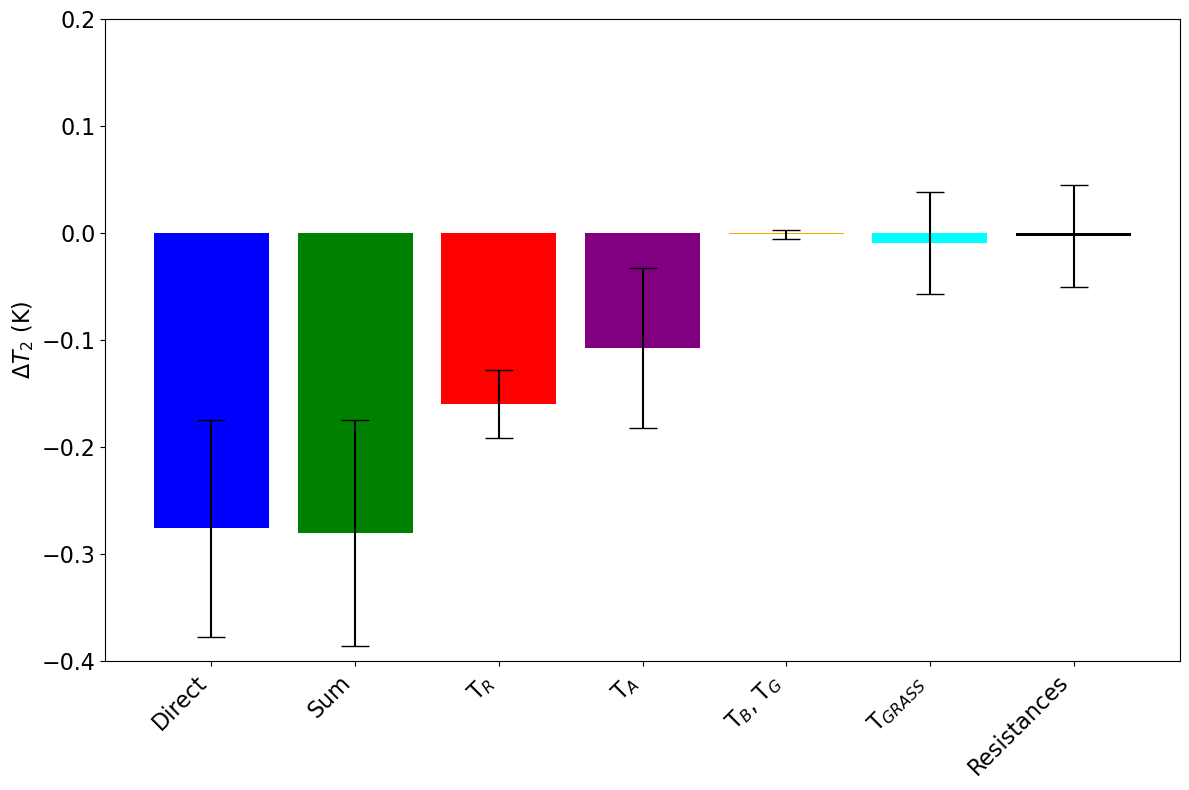

In [219]:
# Set up a single plot
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize as needed

labels = ["Direct", "Sum", "T$_R$", "T$_A$", "T$_B$, T$_G$", "T$_{GRASS}$", "Resistances"]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'black']

# Assuming we want to plot for utype = "all"
utype = 3
values = decomposed_values[utype]
std_devs = decomposed_std_dev[utype]

# Plot bar chart with error bars
ax.bar(labels, values, color=colors[:len(labels)], yerr=std_devs, capsize=10)  # Added yerr for error bars and capsize for cap size on error bars

# Set title
#ax.set_title(f'Urban type = {utype}', fontsize=title_font_size)

# Customize x-axis labels
ax.set_xticklabels(labels, rotation=45, ha="right")  # Align labels at a 45-degree angle
ax.set_ylim(-0.4, 0.2)  # Adjust y-limits if necessary
ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)

# Set y-axis label
ax.set_ylabel('$\Delta T_{2}$ (K)', fontsize=axis_label_font_size)

# Adjust layout to prevent overlap and ensure everything fits neatly
plt.tight_layout()

# Display the plot
plt.show()

## decomposition of T2 for positive and negative ACEs seperately

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


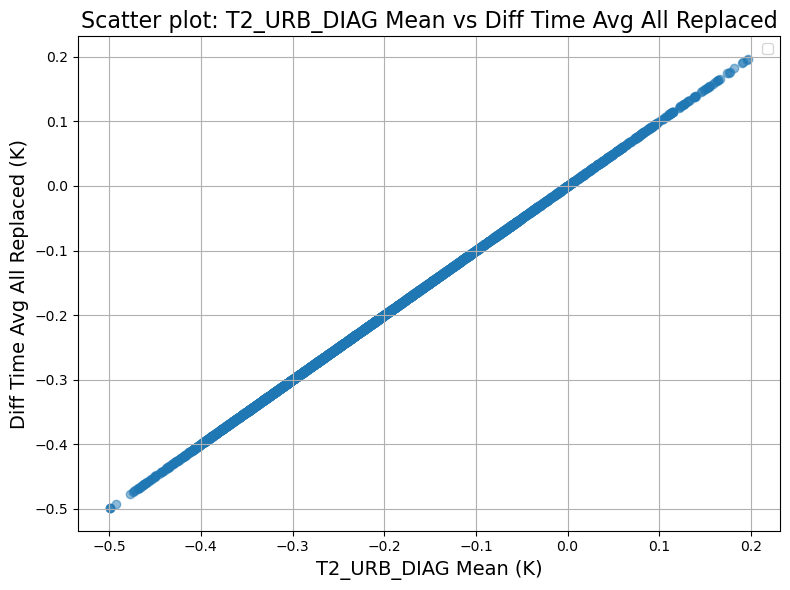

In [220]:
#%% 
decomposed_values = {}
decomposed_std_dev = {}
utypes = ["all"]

ds_ctl = datasets_ctl[folder_paths[0]]  # Access the control dataset for the first folder path
ds_alb = datasets_alb[folder_paths[0]]  # Access the albedo dataset for the first folder path

# Iterate over urban types (e.g., all, 1, 2, 3)
for utype in utypes:
    if utype == "all":
        folder_1_filtered = ds_ctl
    else:
        folder_1_filtered = ds_ctl.where(ds_ctl['UTYPE_URB'] == utype)
        
    # For the albedo dataset (ds_alb)
    if utype == "all":
        ds_filtered = ds_alb
    else:
        ds_filtered = ds_alb.where(ds_alb['UTYPE_URB'] == utype)

    # Calculate baseline time average for T2_URB_DIAG in the control dataset
    folder_1_ts_urb_diag_baseline_time_avg = folder_1_filtered['T2_URB_DIAG'].mean(dim='Time')
    
    # Compute the overall time-averaged difference for the albedo dataset
    overall_diff_time_avg = ds_filtered['T2_URB_DIAG'].mean(dim='Time') - folder_1_ts_urb_diag_baseline_time_avg
    
    # Separate positive and negative values for overall difference
    overall_positive = overall_diff_time_avg.where(overall_diff_time_avg > 0)
    overall_negative = overall_diff_time_avg.where(overall_diff_time_avg <= 0)

    overall_spatial_avg_positive = overall_positive.mean(['south_north', 'west_east']).values
    overall_spatial_std_dev_positive = overall_positive.std(['south_north', 'west_east']).values
    
    overall_spatial_avg_negative = overall_negative.mean(['south_north', 'west_east']).values
    overall_spatial_std_dev_negative = overall_negative.std(['south_north', 'west_east']).values

    results_positive = []
    results_negative = []
    std_devs_positive = []
    std_devs_negative = []

    # Compute the T2_URB_DIAG using different parameter sets
    for compute_func, params in [
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TR_URB": ds_filtered['TR_URB']}),
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TA_URB": ds_filtered['TA_URB']}),
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TB_URB": ds_filtered['TB_URB'], "TG_URB": ds_filtered['TG_URB']}),   
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TS_RUL": ds_filtered['TS_RUL'], "Q_RUL": ds_filtered['Q_RUL']}),         
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"ALPHAR_URB2D": ds_filtered['ALPHAR_URB2D'], "ALPHAB_URB2D": ds_filtered['ALPHAB_URB2D'], "ALPHAG_URB2D": ds_filtered['ALPHAG_URB2D'], "ALPHAC_URB2D": ds_filtered['ALPHAC_URB2D'], "CHS_URB2D": ds_filtered['CHS_URB2D'], "CHS2_URB2D": ds_filtered['CHS2_URB2D']})        
    ]:
        # Calculate the difference in time averages between albedo and control datasets
        diff_time_avg = compute_func(folder_1_filtered, **params).mean(dim='Time') - folder_1_ts_urb_diag_baseline_time_avg
        
        # Separate positive and negative values
        positive_values = diff_time_avg.where(overall_diff_time_avg > 0)
        negative_values = diff_time_avg.where(overall_diff_time_avg <= 0)
        
        # Calculate mean and standard deviation for positive values 
        spatial_avg_positive = positive_values.mean(['south_north', 'west_east']).values
        spatial_std_dev_positive = positive_values.std(['south_north', 'west_east']).values
        
        # Calculate mean and standard deviation for negative values 
        spatial_avg_negative = negative_values.mean(['south_north', 'west_east']).values
        spatial_std_dev_negative = negative_values.std(['south_north', 'west_east']).values

        results_positive.append(spatial_avg_positive)
        results_negative.append(spatial_avg_negative)
        std_devs_positive.append(spatial_std_dev_positive)
        std_devs_negative.append(spatial_std_dev_negative)

    # Cumulative sum of positive results and negative results
    cumulative_sum_positive = sum(results_positive)
    cumulative_sum_negative = sum(results_negative)
    
    cumulative_sum_std_dev_positive = np.sqrt(sum([std_dev**2 for std_dev in std_devs_positive]))
    cumulative_sum_std_dev_negative = np.sqrt(sum([std_dev**2 for std_dev in std_devs_negative]))

    # Store the results for positive and negative separately for each urban type
    decomposed_values[(utype, 'positive')] = [overall_spatial_avg_positive, cumulative_sum_positive] + results_positive
    decomposed_values[(utype, 'negative')] = [overall_spatial_avg_negative, cumulative_sum_negative] + results_negative

    decomposed_std_dev[(utype, 'positive')] = [overall_spatial_std_dev_positive, cumulative_sum_std_dev_positive] + std_devs_positive
    decomposed_std_dev[(utype, 'negative')] = [overall_spatial_std_dev_negative, cumulative_sum_std_dev_negative] + std_devs_negative


    # Now add the new block where all variables are replaced and diff_time_avg is computed
    all_params = {
        "TR_URB": ds_filtered['TR_URB'],
        "TA_URB": ds_filtered['TA_URB'],
        "TB_URB": ds_filtered['TB_URB'],
        "TG_URB": ds_filtered['TG_URB'],
        "ALPHAR_URB2D": ds_filtered['ALPHAR_URB2D'],
        "ALPHAB_URB2D": ds_filtered['ALPHAB_URB2D'],
        "ALPHAG_URB2D": ds_filtered['ALPHAG_URB2D'],
        "ALPHAC_URB2D": ds_filtered['ALPHAC_URB2D'],
        "CHS_URB2D": ds_filtered['CHS_URB2D'],
        "CHS2_URB2D": ds_filtered['CHS2_URB2D'],
        "Q_RUL": ds_filtered['Q_RUL'],
        "TS_RUL": ds_filtered['TS_RUL']
    }

    # Compute the difference in time averages with all variables replaced
    diff_time_avg_all_replaced = compute_T2_URB_DIAG_TC_NOT_INCLUDED(folder_1_filtered, **all_params).mean(dim='Time') - folder_1_ts_urb_diag_baseline_time_avg

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(overall_diff_time_avg.values.flatten(), diff_time_avg_all_replaced.values.flatten(), marker='o', alpha=0.5)

    # Customize the plot
    plt.xlabel('T2_URB_DIAG Mean (K)', fontsize=14)
    plt.ylabel('Diff Time Avg All Replaced (K)', fontsize=14)
    plt.title('Scatter plot: T2_URB_DIAG Mean vs Diff Time Avg All Replaced', fontsize=16)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

## decomposition of T2 for positive and negative ACEs seperately, and all ACEs

In [221]:
decomposed_values = {}
decomposed_std_dev = {}
positive_negative_fractions = {}  # Dictionary to store the fractions for positive and negative values
utypes = ["all"]

ds_ctl = datasets_ctl[folder_paths[0]]  # Access the control dataset for the first folder path
ds_alb = datasets_alb[folder_paths[0]]  # Access the albedo dataset for the first folder path

# Iterate over urban types (e.g., all, 1, 2, 3)
for utype in utypes:
    if utype == "all":
        folder_1_filtered = ds_ctl
    else:
        folder_1_filtered = ds_ctl.where(ds_ctl['UTYPE_URB'] == utype)
        
    # For the albedo dataset (ds_alb)
    if utype == "all":
        ds_filtered = ds_alb
    else:
        ds_filtered = ds_alb.where(ds_alb['UTYPE_URB'] == utype)

    # Calculate baseline time average for T2_URB_DIAG in the control dataset
    folder_1_ts_urb_diag_baseline_time_avg = folder_1_filtered['T2_URB_DIAG'].mean(dim='Time')
    
    # Compute the overall time-averaged difference for the albedo dataset
    overall_diff_time_avg = ds_filtered['T2_URB_DIAG'].mean(dim='Time') - folder_1_ts_urb_diag_baseline_time_avg
    
    # Separate positive and negative values for overall difference
    overall_positive = overall_diff_time_avg.where(overall_diff_time_avg > 0)
    overall_negative = overall_diff_time_avg.where(overall_diff_time_avg <= 0)
    
    # Add new block for all values (regardless of sign)
    overall_all_values = overall_diff_time_avg  # All changes (no filter for sign)

    # Calculate the spatial mean and std for positive, negative, and all values
    overall_spatial_avg_positive = overall_positive.mean(['south_north', 'west_east']).values
    overall_spatial_std_dev_positive = overall_positive.std(['south_north', 'west_east']).values
    
    overall_spatial_avg_negative = overall_negative.mean(['south_north', 'west_east']).values
    overall_spatial_std_dev_negative = overall_negative.std(['south_north', 'west_east']).values

    overall_spatial_avg_all = overall_all_values.mean(['south_north', 'west_east']).values
    overall_spatial_std_dev_all = overall_all_values.std(['south_north', 'west_east']).values

    results_positive = []
    results_negative = []
    results_all = []
    
    std_devs_positive = []
    std_devs_negative = []
    std_devs_all = []

    # Compute the T2_URB_DIAG using different parameter sets
    for compute_func, params in [
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TR_URB": ds_filtered['TR_URB']}),
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TA_URB": ds_filtered['TA_URB']}),
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TB_URB": ds_filtered['TB_URB'], "TG_URB": ds_filtered['TG_URB']}),   
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"TS_RUL": ds_filtered['TS_RUL'], "Q_RUL": ds_filtered['Q_RUL']}),         
        (compute_T2_URB_DIAG_TC_NOT_INCLUDED, {"ALPHAR_URB2D": ds_filtered['ALPHAR_URB2D'], "ALPHAB_URB2D": ds_filtered['ALPHAB_URB2D'], "ALPHAG_URB2D": ds_filtered['ALPHAG_URB2D'], "ALPHAC_URB2D": ds_filtered['ALPHAC_URB2D'], "CHS_URB2D": ds_filtered['CHS_URB2D'], "CHS2_URB2D": ds_filtered['CHS2_URB2D']})        
    ]:
        # Calculate the difference in time averages between albedo and control datasets
        diff_time_avg = compute_func(folder_1_filtered, **params).mean(dim='Time') - folder_1_ts_urb_diag_baseline_time_avg
        
        # Separate positive, negative, and compute all values
        positive_values = diff_time_avg.where(overall_diff_time_avg > 0)
        negative_values = diff_time_avg.where(overall_diff_time_avg <= 0)
        all_values = diff_time_avg  # No filter for sign

        # Calculate mean and standard deviation for positive, negative, and all values
        spatial_avg_positive = positive_values.mean(['south_north', 'west_east']).values
        spatial_std_dev_positive = positive_values.std(['south_north', 'west_east']).values
        
        spatial_avg_negative = negative_values.mean(['south_north', 'west_east']).values
        spatial_std_dev_negative = negative_values.std(['south_north', 'west_east']).values
        
        spatial_avg_all = all_values.mean(['south_north', 'west_east']).values
        spatial_std_dev_all = all_values.std(['south_north', 'west_east']).values

        results_positive.append(spatial_avg_positive)
        results_negative.append(spatial_avg_negative)
        results_all.append(spatial_avg_all)

        std_devs_positive.append(spatial_std_dev_positive)
        std_devs_negative.append(spatial_std_dev_negative)
        std_devs_all.append(spatial_std_dev_all)

    # Cumulative sum of positive, negative, and all results
    cumulative_sum_positive = sum(results_positive)
    cumulative_sum_negative = sum(results_negative)
    cumulative_sum_all = sum(results_all)
    
    cumulative_sum_std_dev_positive = np.sqrt(sum([std_dev**2 for std_dev in std_devs_positive]))
    cumulative_sum_std_dev_negative = np.sqrt(sum([std_dev**2 for std_dev in std_devs_negative]))
    cumulative_sum_std_dev_all = np.sqrt(sum([std_dev**2 for std_dev in std_devs_all]))

    # Store the results for positive, negative, and all changes for each urban type
    decomposed_values[(utype, 'positive')] = [overall_spatial_avg_positive, cumulative_sum_positive] + results_positive
    decomposed_values[(utype, 'negative')] = [overall_spatial_avg_negative, cumulative_sum_negative] + results_negative
    decomposed_values[(utype, 'all')] = [overall_spatial_avg_all, cumulative_sum_all] + results_all

    decomposed_std_dev[(utype, 'positive')] = [overall_spatial_std_dev_positive, cumulative_sum_std_dev_positive] + std_devs_positive
    decomposed_std_dev[(utype, 'negative')] = [overall_spatial_std_dev_negative, cumulative_sum_std_dev_negative] + std_devs_negative
    decomposed_std_dev[(utype, 'all')] = [overall_spatial_std_dev_all, cumulative_sum_std_dev_all] + std_devs_all

    # Compute total non-zero values excluding NaNs
    total_non_zero_values = np.sum((overall_diff_time_avg != 0) & (~np.isnan(overall_diff_time_avg))).compute()

    # Compute number of positive and negative values excluding NaNs
    positive_count = np.sum((overall_diff_time_avg > 0) & (~np.isnan(overall_diff_time_avg))).compute()
    negative_count = np.sum((overall_diff_time_avg <= 0) & (~np.isnan(overall_diff_time_avg))).compute()


    # Compute the fractions
    positive_fraction = positive_count / total_non_zero_values
    negative_fraction = negative_count / total_non_zero_values

    # Print the total number of non-zero values and the fractions
    print(f"Urban type: {utype}")
    print(f"Total non-zero values: {total_non_zero_values}")
    print(f"Number of positive values: {positive_count}")
    print(f"Number of negative values: {negative_count}")
    print(f"Fraction of positive values: {positive_fraction:.1%}")
    print(f"Fraction of negative values: {negative_fraction:.1%}")
    # Store the fractions for later use in plotting
    positive_negative_fractions[utype] = {'positive': positive_fraction, 'negative': negative_fraction}

Urban type: all
Total non-zero values: <xarray.DataArray 'T2_URB_DIAG' ()>
array(3944)
Number of positive values: <xarray.DataArray 'T2_URB_DIAG' ()>
array(348)
Number of negative values: <xarray.DataArray 'T2_URB_DIAG' ()>
array(3596)
Fraction of positive values: 8.8%
Fraction of negative values: 91.2%


## decomposition of T2 (plot)

/var/folders/db/c54v0_4d5wb4gtcwcv819y2h0000gn/T/ipykernel_21195/1775177256.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[:len(negative_values)], rotation=45, ha="right")
/var/folders/db/c54v0_4d5wb4gtcwcv819y2h0000gn/T/ipykernel_21195/1775177256.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[:len(positive_values)], rotation=45, ha="right")
/var/folders/db/c54v0_4d5wb4gtcwcv819y2h0000gn/T/ipykernel_21195/1775177256.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[:len(all_values)], rotation=45, ha="right")


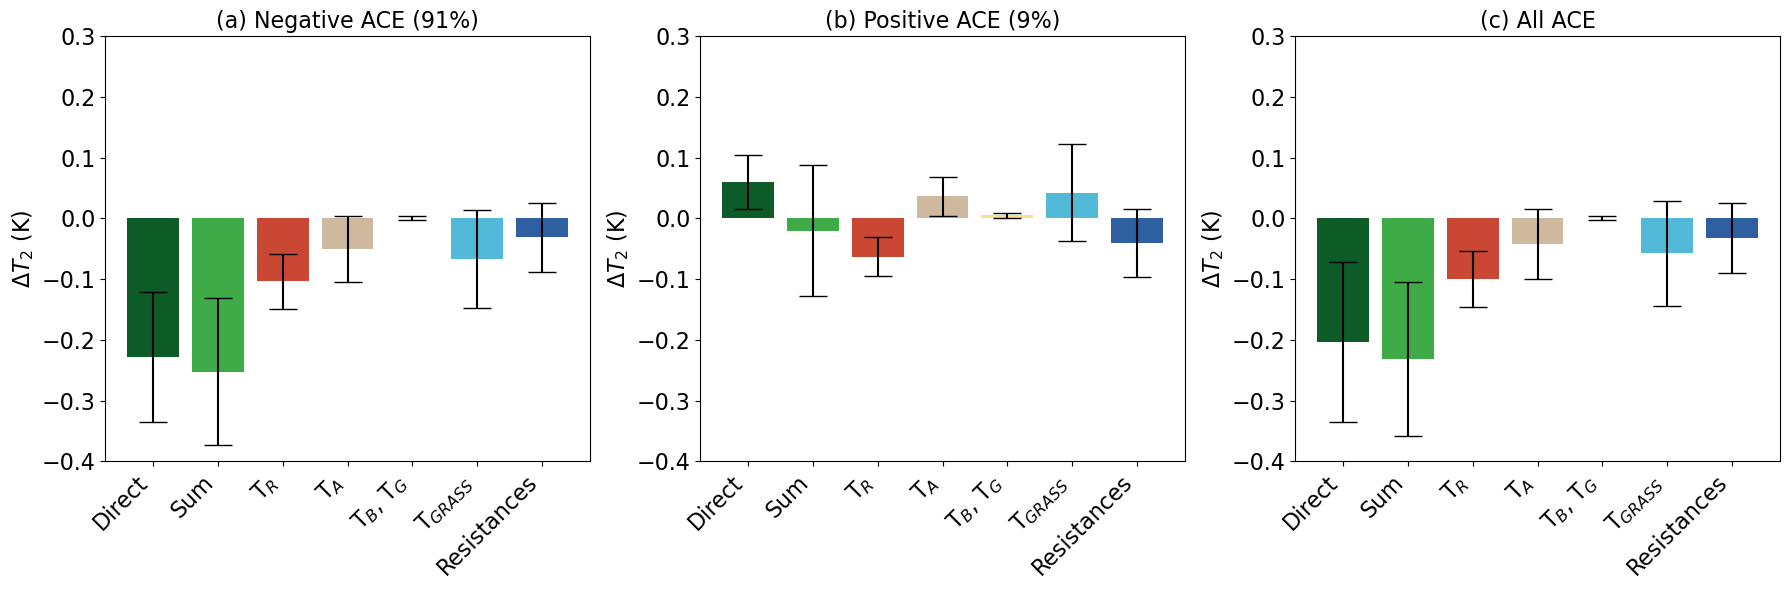

In [222]:
# Set up a 1x3 grid of subplots (3 subplots total)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjusted figure size for 3 subplots
labels = ["Direct", "Sum", "T$_R$", "T$_A$", "T$_B$, T$_G$", "T$_{GRASS}$", "Resistances"]
#colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'black']
colors = [
    (13/255, 91/255, 38/255),   # Dark Green
    (63/255, 171/255, 71/255),  # Green
    (201/255, 71/255, 51/255),  # Red
    (207/255, 185/255, 158/255),
    (253/255, 223/255, 139/255),# Light Yellow
    (82/255, 185/255, 216/255), # Light Blue
    (46/255, 95/255, 161/255)   # Dark Blue
]
# Get values and std_devs for utype = "all" (positive, negative, and all values)
positive_values = decomposed_values[("all", 'positive')]
positive_std_devs = decomposed_std_dev[("all", 'positive')]

negative_values = decomposed_values[("all", 'negative')]
negative_std_devs = decomposed_std_dev[("all", 'negative')]

all_values = decomposed_values[("all", 'all')]
all_std_devs = decomposed_std_dev[("all", 'all')]

# Use the previously calculated fractions for the titles
# Replace these with the fractions you calculated earlier
positive_fraction = positive_negative_fractions["all"]['positive']
negative_fraction = positive_negative_fractions["all"]['negative']

# Define subplot titles for positive, negative, and all values with fractions
subplot_titles = [
    f'(a) Negative ACE ({negative_fraction:.0%})',
    f'(b) Positive ACE ({positive_fraction:.0%})',
    '(c) All ACE'
]

# Plot for negative decomposed values
ax = axes[0]
ax.bar(labels[:len(negative_values)], negative_values, color=colors[:len(negative_values)], yerr=negative_std_devs, capsize=10)
ax.set_title(subplot_titles[0], fontsize=title_font_size)
ax.set_xticklabels(labels[:len(negative_values)], rotation=45, ha="right")
ax.set_ylim(-0.4, 0.3)
ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax.set_ylabel('$\Delta T_{2}$ (K)', fontsize=axis_label_font_size)

# Plot for positive decomposed values
ax = axes[1]
ax.bar(labels[:len(positive_values)], positive_values, color=colors[:len(positive_values)], yerr=positive_std_devs, capsize=10)
ax.set_title(subplot_titles[1], fontsize=title_font_size)
ax.set_xticklabels(labels[:len(positive_values)], rotation=45, ha="right")
ax.set_ylim(-0.4, 0.3)
ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax.set_ylabel('$\Delta T_{2}$ (K)', fontsize=axis_label_font_size)

# Plot for all changes (positive + negative combined)
ax = axes[2]
ax.bar(labels[:len(all_values)], all_values, color=colors[:len(all_values)], yerr=all_std_devs, capsize=10)
ax.set_title(subplot_titles[2], fontsize=title_font_size)
ax.set_xticklabels(labels[:len(all_values)], rotation=45, ha="right")
ax.set_ylim(-0.4, 0.3)  # Adjusting the y-limit to accommodate all changes
ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size)
ax.set_ylabel('$\Delta T_{2}$ (K)', fontsize=axis_label_font_size)

# Adjust layout to prevent overlap and ensure everything fits neatly
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
fig.savefig("figures/T2_decomposition_all_changes.png", dpi=300)

Case YSU - Coefficient of Variation for Panel A (ACE): 4.22
Case YSU - Coefficient of Variation for Panel B (ACE_s): 0.06
Case YSU - Coefficient of Variation for Panel C (ACS_s): 0.04
Case YSU - Median ACE: 2.16
Case MYNN - Coefficient of Variation for Panel A (ACE): 9.39
Case MYNN - Coefficient of Variation for Panel B (ACE_s): 0.07
Case MYNN - Coefficient of Variation for Panel C (ACS_s): 0.04
Case MYNN - Median ACE: 2.19
Case MYJ - Coefficient of Variation for Panel A (ACE): 1.19
Case MYJ - Coefficient of Variation for Panel B (ACE_s): 0.05
Case MYJ - Coefficient of Variation for Panel C (ACS_s): 0.04
Case MYJ - Median ACE: 3.27
The fitted line explains 44.40% of the variability in the data.


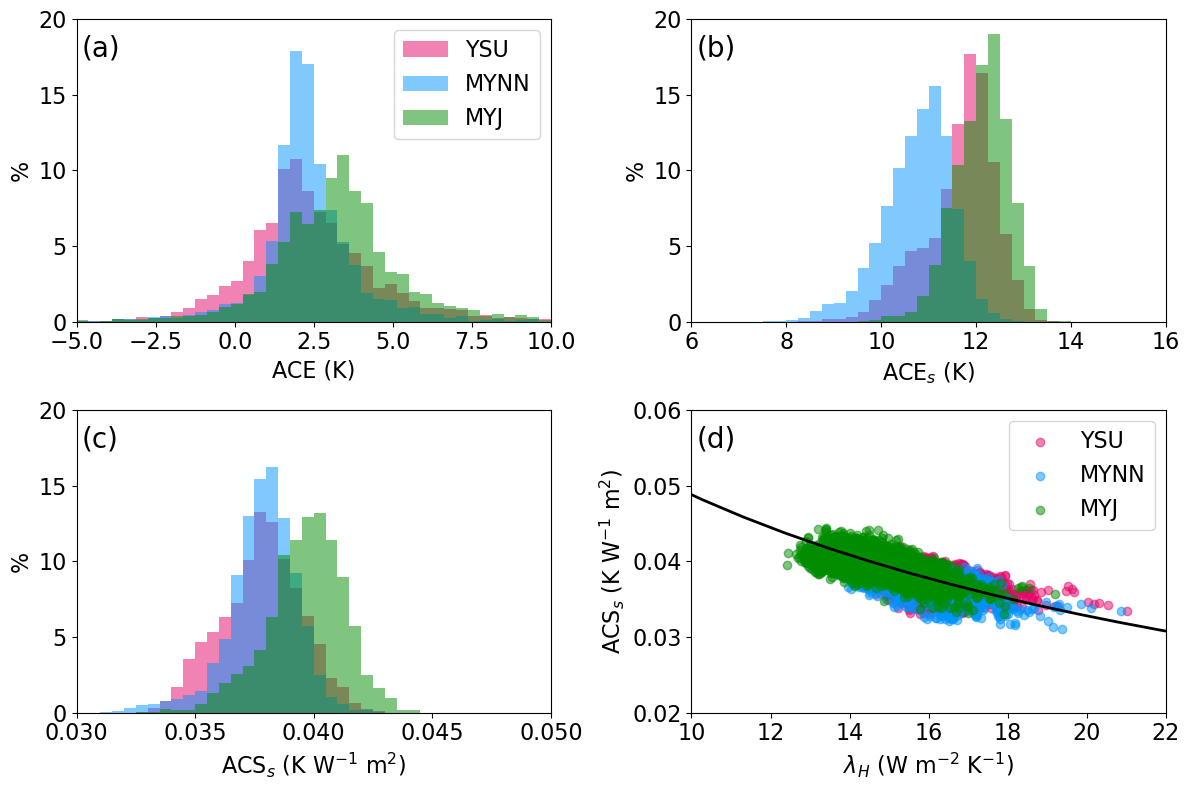

In [228]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import gaussian_kde  # For kernel density estimation (KDE)

convertion_factor = 0.001 * 0.24 / 1004.5
variable = 'TR_URB'  # Set the variable to be plotted

# Define custom colors for each case
#custom_colors = ['black', 'blue', 'red', 'green', 'orange']  # Custom colors for the 5 cases
custom_colors = [
    (229/255, 8/255, 106/255),   # Pink
    (0/255, 148/255, 255/255),  # Blue
    (0/255, 141/255, 0/255),    # Green
    (255/255, 146/255, 0/255),  # Orange
    (207/255, 185/255, 158/255) # Beige
]

# Define custom labels for the 5 cases
custom_labels = ['YSU', 'MYNN', 'MYJ']

# Create a figure with four subplots (2 rows, 2 columns)
fig, ((ax_hist1, ax_hist2), (ax_hist3, ax_scatter)) = plt.subplots(2, 2, figsize=(12, 8))  # Adjusted figure size for 2x2 layout

# Add labels (a), (b), (c), (d) to the top-left corner of each subplot
ax_hist1.text(0.01, 0.95, '(a)', transform=ax_hist1.transAxes, fontsize=20, verticalalignment='top')
ax_hist2.text(0.01, 0.95, '(b)', transform=ax_hist2.transAxes, fontsize=20, verticalalignment='top')
ax_hist3.text(0.01, 0.95, '(c)', transform=ax_hist3.transAxes, fontsize=20, verticalalignment='top')
ax_scatter.text(0.01, 0.95, '(d)', transform=ax_scatter.transAxes, fontsize=20, verticalalignment='top')


# Iterate over folder paths to collect data for the three PDF plots
hist_data_ACS_s = []
hist_data_ACE_s = []
hist_data_ACE = []
scatter_data_x = []
scatter_data_y = []
scatter2_data_x = []
scatter2_data_y = []
scatter3_data_x = []
scatter3_data_y = []
total_non_zero_values = []  # To store total non-zero values for normalization

selected_indices = [0, 1, 2]  # Specify the indices you want

for i in selected_indices:
    folder = folder_paths[i]
    ds_ctl = datasets_ctl[folder]
    ds_alb = datasets_alb[folder]

    # Average in time
    forcing_avg = ds_ctl['FORCING_ROOF'].mean(dim='Time').compute()
    wind_speed_avg = ds_ctl['wind_speed_10'].mean(dim='Time').compute()
    delta_Ts_avg = ds_ctl[variable].mean(dim='Time').compute() - ds_alb[variable].mean(dim='Time').compute()
    ALPHAR_URB2D_avg_ctl = ds_ctl['ALPHAR_URB2D'].mean(dim='Time').compute() / convertion_factor
    ALPHAR_URB2D_avg_alb = ds_alb['ALPHAR_URB2D'].mean(dim='Time').compute() / convertion_factor

    # Calculate the ACS_s normalized by forcing
    ACS_s = delta_Ts_avg / forcing_avg
    ACE_s = delta_Ts_avg / (ds_ctl['Delta_ALBEDO_ROOF'].mean(dim='Time').compute())

    # Apply the condition to filter values where UTYPE_URB != 0
    urban_type_mask = (ds_ctl['UTYPE_URB'].isel(Time=0) != 0)
    
    # Calculate ACE (positive or negative)
    ACE = -(ds_alb['T2'].mean(dim='Time') - ds_ctl['T2'].mean(dim='Time')) / (ds_ctl['Delta_ALBEDO_GRID'].mean(dim='Time'))
    
    # Create a mask based on whether ACE is positive or negative
    ACE_mask = ACE < 0  # For positive values, use (ACE <= 0) for negative values

    # Combine both masks
    combined_mask = urban_type_mask  # & ACE_mask
    
    # Apply the mask and collect the filtered data
    ACS_s_filtered = ACS_s#.where(combined_mask)
    ACE_s_filtered = ACE_s#.where(combined_mask)
    ACE_filtered = ACE#.where(combined_mask)
    ALPHAR_URB2D_avg_ctl_filtered = ALPHAR_URB2D_avg_ctl#.where(combined_mask)
    # Collect data for the PDFs
    ACS_s_values = ACS_s_filtered.values[~np.isnan(ACS_s_filtered.values)]
    ACE_s_values = ACE_s_filtered.values[~np.isnan(ACE_s_filtered.values)]
    ACE_values = ACE_filtered.values[~np.isnan(ACE_filtered.values)]

    # Collect the coefficient of variation (CV) for each panel
    cv_ACS_s = np.std(ACS_s_values) / np.mean(ACS_s_values)
    cv_ACE_s = np.std(ACE_s_values) / np.mean(ACE_s_values)
    cv_ACE = np.std(ACE_values) / np.mean(ACE_values)

    # Print out the CV values for each panel
    print(f"Case {custom_labels[i]} - Coefficient of Variation for Panel A (ACE): {cv_ACE:.2f}")
    print(f"Case {custom_labels[i]} - Coefficient of Variation for Panel B (ACE_s): {cv_ACE_s:.2f}")
    print(f"Case {custom_labels[i]} - Coefficient of Variation for Panel C (ACS_s): {cv_ACS_s:.2f}")


    total_non_zero_values.append(np.sum(ACS_s_values != 0))
    hist_data_ACS_s.append(ACS_s_values)
    hist_data_ACE_s.append(ACE_s_values)
    hist_data_ACE.append(ACE_values)
    
    # Compute and print the median of ACE
    median_ACE = np.median(ACE_values)
    print(f"Case {custom_labels[i]} - Median ACE: {median_ACE:.2f}")    

    # Collect data for scatter plot
    scatter_data_x.append(ALPHAR_URB2D_avg_ctl.where(ds_ctl['UTYPE_URB'].isel(Time=0) != 0).values.flatten())
    scatter_data_y.append(ACS_s_filtered.values.flatten())
    # scatter2_data_x.append(ALPHAR_URB2D_avg_ctl.where(ds_ctl['UTYPE_URB'].isel(Time=0) == 2).values.flatten())
    # scatter2_data_y.append(ACS_s_filtered.values.flatten())
    # scatter3_data_x.append(ALPHAR_URB2D_avg_ctl.where(ds_ctl['UTYPE_URB'].isel(Time=0) == 3).values.flatten())
    # scatter3_data_y.append(ACS_s_filtered.values.flatten())

# Plot first PDF (ACE_norm) in the first subplot (swapped position)
for idx, i in enumerate(selected_indices):
    data = hist_data_ACE[idx]  # Use idx to access the correct data
    ax_hist1.hist(data, bins=40, range=(-5, 10), alpha=0.5, color=custom_colors[i], label=custom_labels[i], 
                 weights=np.ones_like(data)*100 / total_non_zero_values[idx])  # Normalize by total_non_zero_values
    
# Set titles and labels for the first PDF (ACE_norm)
ax_hist1.set_xlabel('ACE (K)', fontsize=16)
ax_hist1.set_ylabel('%', fontsize=16)
ax_hist1.set_xlim(-5, 10)
ax_hist1.set_ylim(0, 20)
ax_hist1.legend(fontsize=16)

# Increase font size of ticks for the first PDF
ax_hist1.tick_params(axis='x', labelsize=16)
ax_hist1.tick_params(axis='y', labelsize=16)

# Plot second PDF (ACE_s) in the second subplot
for idx, i in enumerate(selected_indices):
    data = hist_data_ACE_s[idx]  # Use idx to access the correct data

    ax_hist2.hist(data, bins=40, range=(6, 16), alpha=0.5, color=custom_colors[i], 
                 weights=np.ones_like(data)*100 / total_non_zero_values[idx])  # Normalize by total_non_zero_values
    
# Set titles and labels for the second PDF
ax_hist2.set_xlabel(r'ACE$_s$ (K)', fontsize=16)
ax_hist2.set_ylabel('%', fontsize=16)
ax_hist2.set_xlim(6, 16)
ax_hist2.set_ylim(0, 20)
# ax_hist2.legend(fontsize=16)

# Increase font size of ticks for the second PDF
ax_hist2.tick_params(axis='x', labelsize=16)
ax_hist2.tick_params(axis='y', labelsize=16)

# Plot third PDF (ACS_s) in the third subplot
for idx, i in enumerate(selected_indices):
    data = hist_data_ACS_s[idx]  # Use idx to access the correct data

    ax_hist3.hist(data, bins=40, range=(0.03, 0.05), alpha=0.5, color=custom_colors[i], 
                 weights=np.ones_like(data)*100 / total_non_zero_values[idx])  # Normalize by total_non_zero_values
    
# Set titles and labels for the third PDF (ACS_s)
ax_hist3.set_xlabel(r'ACS$_s$ (K W$^{-1}$ m$^{2}$)', fontsize=16)
ax_hist3.set_ylabel('%', fontsize=16)
ax_hist3.set_xlim(0.03, 0.05)
ax_hist3.set_ylim(0, 20)
ax_hist3.xaxis.set_major_locator(mticker.MultipleLocator(0.005))
ax_hist3.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
# ax_hist3.legend(fontsize=16)

# Increase font size of ticks for the third PDF
ax_hist3.tick_params(axis='x', labelsize=16)
ax_hist3.tick_params(axis='y', labelsize=16)

# Add scatter plot in the fourth subplot
for idx, i in enumerate(selected_indices):
    ax_scatter.scatter(scatter_data_x[idx], scatter_data_y[idx], alpha=0.5, color=custom_colors[i], label=custom_labels[i])

# Set titles and labels for the scatter plot
ax_scatter.set_xlabel(r'$\lambda_H$ (W m$^{-2}$ K$^{-1}$)', fontsize=16)
ax_scatter.set_ylabel(r'ACS$_s$ (K W$^{-1}$ m$^{2}$)', fontsize=16)
ax_scatter.set_xlim(10, 22)
ax_scatter.set_ylim(0.02, 0.06)

# Add a linear line to the scatter plot
x_values = np.linspace(5, 25, 20)
y_values = 1 / (x_values + 10.5)
ax_scatter.plot(x_values, y_values, color='black', linestyle='-', linewidth=2)
# Add a legend to the scatter plot
ax_scatter.legend(fontsize=16)


# Increase font size of ticks for the scatter plot
ax_scatter.tick_params(axis='x', labelsize=16)
ax_scatter.tick_params(axis='y', labelsize=16)

# Add a legend to the scatter plot
ax_scatter.legend(fontsize=16)

# Compute y values for the fitted line
y_fit = 1 / (np.array(scatter_data_x).flatten() + 10.5)

# Get the actual y-values from the scatter data
y_actual = np.array(scatter_data_y).flatten()

# Remove NaNs for accurate calculations
valid_mask = ~np.isnan(y_actual) & ~np.isnan(y_fit)
y_actual = y_actual[valid_mask]
y_fit = y_fit[valid_mask]

# Calculate SST (total sum of squares)
sst = np.sum((y_actual - np.mean(y_actual)) ** 2)

# Calculate SSR (residual sum of squares)
ssr = np.sum((y_actual - y_fit) ** 2)

# Calculate R^2
r_squared = 1 - (ssr / sst)

# Print the percentage of variability explained by the line
print(f"The fitted line explains {r_squared * 100:.2f}% of the variability in the data.")

# Adjust layout to prevent overlap and ensure everything fits neatly
plt.tight_layout()

# Show the figure with both subplots
plt.show()
fig.savefig("figures/combined_histgrams.png", dpi=300)

## the PDFs of SWin and wind speed

Case YSU - Coefficient of Variation for Panel A (ACE_norm): 4.222
Case YSU - Coefficient of Variation for Panel B (ACE_s): 0.063
Case YSU - Coefficient of Variation for Panel C (ACS_s): 0.045
Case YSU - Total non-zero values: 3944
Case YSU - Median ACE_norm: 2.157
Case MYNN - Coefficient of Variation for Panel A (ACE_norm): 9.386
Case MYNN - Coefficient of Variation for Panel B (ACE_s): 0.068
Case MYNN - Coefficient of Variation for Panel C (ACS_s): 0.039
Case MYNN - Total non-zero values: 3944
Case MYNN - Median ACE_norm: 2.194
Case MYJ - Coefficient of Variation for Panel A (ACE_norm): 1.194
Case MYJ - Coefficient of Variation for Panel B (ACE_s): 0.047
Case MYJ - Coefficient of Variation for Panel C (ACS_s): 0.041
Case MYJ - Total non-zero values: 3944
Case MYJ - Median ACE_norm: 3.268


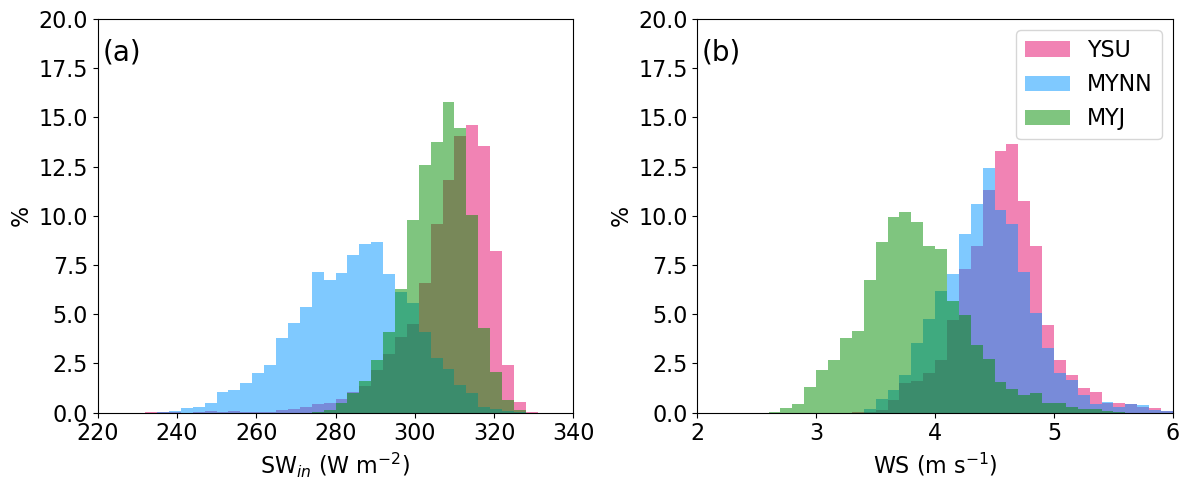

In [229]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import gaussian_kde  # For kernel density estimation (KDE)

convertion_factor = 0.001 * 0.24 / 1004.5
variable = 'TR_URB'  # Set the variable to be plotted

# Define custom colors for each case
#custom_colors = ['black', 'blue', 'red', 'green', 'orange']  # Custom colors for the 5 cases
custom_colors = [
    (229/255, 8/255, 106/255),   # Pink
    (0/255, 148/255, 255/255),  # Blue
    (0/255, 141/255, 0/255),    # Green
    (255/255, 146/255, 0/255),  # Orange
    (207/255, 185/255, 158/255) # Beige
]

# Define custom labels for the 5 cases
custom_labels = ['YSU', 'MYNN', 'MYJ']

# Create a figure with four subplots (2 rows, 2 columns)
fig, (ax_hist1, ax_hist2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjusted figure size for 2x2 layout

# Add labels (a), (b), (c), (d) to the top-left corner of each subplot
ax_hist1.text(0.01, 0.95, '(a)', transform=ax_hist1.transAxes, fontsize=20, verticalalignment='top')
ax_hist2.text(0.01, 0.95, '(b)', transform=ax_hist2.transAxes, fontsize=20, verticalalignment='top')
ax_hist3.text(0.01, 0.95, '(c)', transform=ax_hist3.transAxes, fontsize=20, verticalalignment='top')
ax_scatter.text(0.01, 0.95, '(d)', transform=ax_scatter.transAxes, fontsize=20, verticalalignment='top')


# Iterate over folder paths to collect data for the three PDF plots
hist_data_ACS_s = []
hist_data_ACE_s = []
hist_data_ACE = []
hist_data_wind_speed = []
hist_data_SWDOWN = []

scatter_data_x = []
scatter_data_y = []
scatter2_data_x = []
scatter2_data_y = []
scatter3_data_x = []
scatter3_data_y = []
total_non_zero_values = []  # To store total non-zero values for normalization

selected_indices = [0, 1, 2]  # Specify the indices you want

for i in selected_indices:
    folder = folder_paths[i]
    ds_ctl = datasets_ctl[folder]
    ds_alb = datasets_alb[folder]

    # Average in time
    forcing_avg = ds_ctl['FORCING_ROOF'].mean(dim='Time').compute()
    SWDOWN_avg = ds_ctl['SWDOWN'].mean(dim='Time').compute()
    wind_speed_avg = ds_ctl['wind_speed_10'].mean(dim='Time').compute()
    delta_Ts_avg = ds_ctl[variable].mean(dim='Time').compute() - ds_alb[variable].mean(dim='Time').compute()
    ALPHAR_URB2D_avg_ctl = ds_ctl['ALPHAR_URB2D'].mean(dim='Time').compute() / convertion_factor
    ALPHAR_URB2D_avg_alb = ds_alb['ALPHAR_URB2D'].mean(dim='Time').compute() / convertion_factor

    # Calculate the ACS_s normalized by forcing
    ACS_s = delta_Ts_avg / forcing_avg
    ACE_s = delta_Ts_avg / (ds_ctl['Delta_ALBEDO_ROOF'].mean(dim='Time').compute())

    # Apply the condition to filter values where UTYPE_URB != 0
    urban_type_mask = (ds_ctl['UTYPE_URB'].isel(Time=0) != 0)
    
    # Calculate ACE (positive or negative)
    ACE = -(ds_alb['T2'].mean(dim='Time') - ds_ctl['T2'].mean(dim='Time')) / (ds_ctl['Delta_ALBEDO_GRID'].mean(dim='Time'))
    
    # Create a mask based on whether ACE is positive or negative
    ACE_mask = ACE < 0  # For positive values, use (ACE <= 0) for negative values

    # Combine both masks
    combined_mask = urban_type_mask  # & ACE_mask
    
    # Apply the mask and collect the filtered data
    ACS_s_filtered = ACS_s#.where(combined_mask)
    ACE_s_filtered = ACE_s#.where(combined_mask)
    ACE_filtered = ACE#.where(combined_mask)
    ALPHAR_URB2D_avg_ctl_filtered = ALPHAR_URB2D_avg_ctl#.where(combined_mask)
    wind_speed_avg_filtered = wind_speed_avg.where(urban_type_mask)
    SWDOWN_avg_filtered = SWDOWN_avg.where(urban_type_mask)

    # Collect data for the PDFs
    ACS_s_values = ACS_s_filtered.values[~np.isnan(ACS_s_filtered.values)]
    ACE_s_values = ACE_s_filtered.values[~np.isnan(ACE_s_filtered.values)]
    ACE_values = ACE_filtered.values[~np.isnan(ACE_filtered.values)]
    wind_speed_avg_values = wind_speed_avg_filtered.values[~np.isnan(wind_speed_avg_filtered.values)]
    SWDOWN_avg_values = SWDOWN_avg_filtered.values[~np.isnan(SWDOWN_avg_filtered.values)]

    # Collect the coefficient of variation (CV) for each panel
    cv_ACS_s = np.std(ACS_s_values) / np.mean(ACS_s_values)
    cv_ACE_s = np.std(ACE_s_values) / np.mean(ACE_s_values)
    cv_ACE = np.std(ACE_values) / np.mean(ACE_values)

    # Print out the CV values for each panel
    print(f"Case {custom_labels[i]} - Coefficient of Variation for Panel A (ACE_norm): {cv_ACE:.3f}")
    print(f"Case {custom_labels[i]} - Coefficient of Variation for Panel B (ACE_s): {cv_ACE_s:.3f}")
    print(f"Case {custom_labels[i]} - Coefficient of Variation for Panel C (ACS_s): {cv_ACS_s:.3f}")


    total_non_zero_values.append(np.sum(ACS_s_values != 0))

    print(f"Case {custom_labels[i]} - Total non-zero values: {total_non_zero_values[i]}")

    hist_data_ACS_s.append(ACS_s_values)
    hist_data_ACE_s.append(ACE_s_values)
    hist_data_ACE.append(ACE_values)
    hist_data_wind_speed.append(wind_speed_avg_values)
    hist_data_SWDOWN.append(SWDOWN_avg_values)
    
    # Compute and print the median of ACE_norm
    median_ACE_norm = np.median(ACE_values)
    print(f"Case {custom_labels[i]} - Median ACE_norm: {median_ACE_norm:.3f}")    



# Plot first PDF (ACE_norm) in the first subplot (swapped position)
for idx, i in enumerate(selected_indices):
    data = hist_data_SWDOWN[idx]  # Use idx to access the correct data

    ax_hist1.hist(data, bins=40, range=(220, 340), alpha=0.5, color=custom_colors[i], 
                 weights=np.ones_like(data)*100 / total_non_zero_values[idx])  # Normalize by total_non_zero_values
    
# Set titles and labels for the first PDF (ACE_norm)
ax_hist1.set_xlabel('SW$_{in}$ (W m$^{-2}$)', fontsize=16)
ax_hist1.set_ylabel('%', fontsize=16)
ax_hist1.set_xlim(220, 340)
ax_hist1.set_ylim(0, 20)
# ax_hist1.legend(fontsize=16)

# Increase font size of ticks for the first PDF
ax_hist1.tick_params(axis='x', labelsize=16)
ax_hist1.tick_params(axis='y', labelsize=16)

# Plot second PDF (ACE_s) in the second subplot
for idx, i in enumerate(selected_indices):
    data = hist_data_wind_speed[idx]  # Use idx to access the correct data

    ax_hist2.hist(data, bins=40, range=(2, 6), alpha=0.5, color=custom_colors[i], label=custom_labels[i], 
                 weights=np.ones_like(data)*100 / total_non_zero_values[idx])  # Normalize by total_non_zero_values
    
# Set titles and labels for the second PDF
ax_hist2.set_xlabel('WS (m s$^{-1}$)', fontsize=16)
ax_hist2.set_ylabel('%', fontsize=16)
ax_hist2.set_xlim(2, 6)
ax_hist2.set_ylim(0, 20)
ax_hist2.legend(fontsize=16)

# Increase font size of ticks for the second PDF
ax_hist2.tick_params(axis='x', labelsize=16)
ax_hist2.tick_params(axis='y', labelsize=16)


# Adjust layout to prevent overlap and ensure everything fits neatly
plt.tight_layout()

# Show the figure with both subplots
plt.show()
fig.savefig("figures/windspeed.png", dpi=300)
